In [1]:
%reload_ext autoreload
%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters, SGXConverter
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

In [4]:
SGXConverter.convert_sgx_to_csv()

Found 0 SGX files.
Found 1 CSV files. Proceeding with analysis...


# Read Data

Let's first read in the meta data of all models in the dataset.

In [5]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


revision_id  \
model_id                                                             
c30cb4ce5b8f4e2e826ae5a8fee93c7d  9734fe57bc2c4fe385bfcd0cd5a84c93   
c30cf7c15cce4795991c001694e5fd8b  886eb4088f2d46469b279277149f3309   
c30cf9af3ea04ff291d124c2ebe92eae  fe6d8b3a5e88472eb4ce60dc8ca53728   
c30cfda46f1741e3ba3514c7bc0f4e2b  34c69ec81584414bbbc14faa46bde122   
c30d201c20b8464a92fc1d28e4f43d7f  b0a42358699e43689f24433c2173301d   

                                                   organization_id  \
model_id                                                             
c30cb4ce5b8f4e2e826ae5a8fee93c7d  d6f9654c3d694486a4fd1de2ee93a8ee   
c30cf7c15cce4795991c001694e5fd8b  47cc7384176c47c290ed36cddc66cbe0   
c30cf9af3ea04ff291d124c2ebe92eae  a7236502a8574beba6cdaaf976b63a9c   
c30cfda46f1741e3ba3514c7bc0f4e2b  135e5485039a4878a17ead69fe6f0523   
c30d201c20b8464a92fc1d28e4f43d7f  b12d8e6e307e48718d0bd88f6014b6e2   

                                             datetime  description  \
model_id                                                             
c30cb4ce5b8f4e2e826ae5a8fee93c7d  2019-08-26 05:17:10          NaN   
c30cf7c15cce4795991c001694e5fd8b  2020-04-17 15:23:28          NaN   
c30cf9af3ea04ff291d124c2ebe92eae  2017-09-08 04:24:02          NaN   
c30cfda46f1741e3ba3514c7bc0f4e2b  2018-10-15 11:34:44          NaN   
c30d201c20b8464a92fc1d28e4f43d7f  2021-03-22 07:07:05          NaN   

                                                                        name  \
model_id                                                                       
c30cb4ce5b8f4e2e826ae5a8fee93c7d                  Check quantity and quality   
c30cf7c15cce4795991c001694e5fd8b               Level 1 - Value Chain ACME AG   
c30cf9af3ea04ff291d124c2ebe92eae  Phase 3: Application Documentation (1.1.1)   
c30cfda46f1741e3ba3514c7bc0f4e2b             Kundenauftrag IST-Prozess (alt)   
c30d201c20b8464a92fc1d28e4f43d7f                         Employee Onboarding   

                                 type  \
model_id                                
c30cb4ce5b8f4e2e826ae5a8fee93c7d  NaN   
c30cf7c15cce4795991c001694e5fd8b  NaN   
c30cf9af3ea04ff291d124c2ebe92eae  NaN   
c30cfda46f1741e3ba3514c7bc0f4e2b  NaN   
c30d201c20b8464a92fc1d28e4f43d7f  NaN   

                                                                        namespace  
model_id                                                                           
c30cb4ce5b8f4e2e826ae5a8fee93c7d         http://signavio.com/stencilsets/dmn-1.0#  
c30cf7c15cce4795991c001694e5fd8b  http://www.signavio.com/stencilsets/processmap#  
c30cf9af3ea04ff291d124c2ebe92eae              http://b3mn.org/stencilset/bpmn2.0#  
c30cfda46f1741e3ba3514c7bc0f4e2b                  http://b3mn.org/stencilset/epc#  
c30d201c20b8464a92fc1d28e4f43d7f              http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [6]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [7]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [8]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

677

This is the percentage of example process from the dataset:

In [9]:
len(df_meta_examples)/len(df_meta)

0.460231135282121

This is the number of models in the dataset without example processes (again, based on process names):

In [10]:
len(df_meta)-len(df_meta_examples)

794

And the percentage of models in the dataset without example processes:

In [11]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.539768864717879

We apply the filter to perform the analysis on the dataset without examples processes:

In [12]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

794

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [13]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [14]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
#df_notations = df_notations.replace({'Notation' : d_namespaces})

In [15]:
def map_namespaces(namespace):
    return d_namespaces.get(namespace, 'Unknown')
df_notations['Notation'] = df_notations['Notation'].map(lambda x: map_namespaces(x))
df_notations

Notation  Frequency
0                BPMN 2.0        571
1                     EPC         52
2             Value Chain         29
3           UML 2.2 Class         25
4                BPMN 1.1         22
5               Petri Net         19
6           ArchiMate 2.1         18
7                 DMN 1.0         17
8            UML Use Case         15
9              Organigram          8
10  BPMN 2.0 Choreography          8
11      FMC Block Diagram          4
12  BPMN 2.0 Conversation          3
13            Journey Map          3

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
if df_notations['Notation'].nunique() > 3:
    df_notations = DataFilter(df_notations)
    df_notations = df_notations.filter_data("namespaces", "max", 5)
df_notations

Notation  Frequency
0                BPMN 2.0        571
1                     EPC         52
2             Value Chain         29
3           UML 2.2 Class         25
4                BPMN 1.1         22
5               Petri Net         19
6           ArchiMate 2.1         18
7                 DMN 1.0         17
8            UML Use Case         15
9                   Other         10
10  BPMN 2.0 Choreography          8
11             Organigram          8

We can visualise the number of models in different modeling notations.

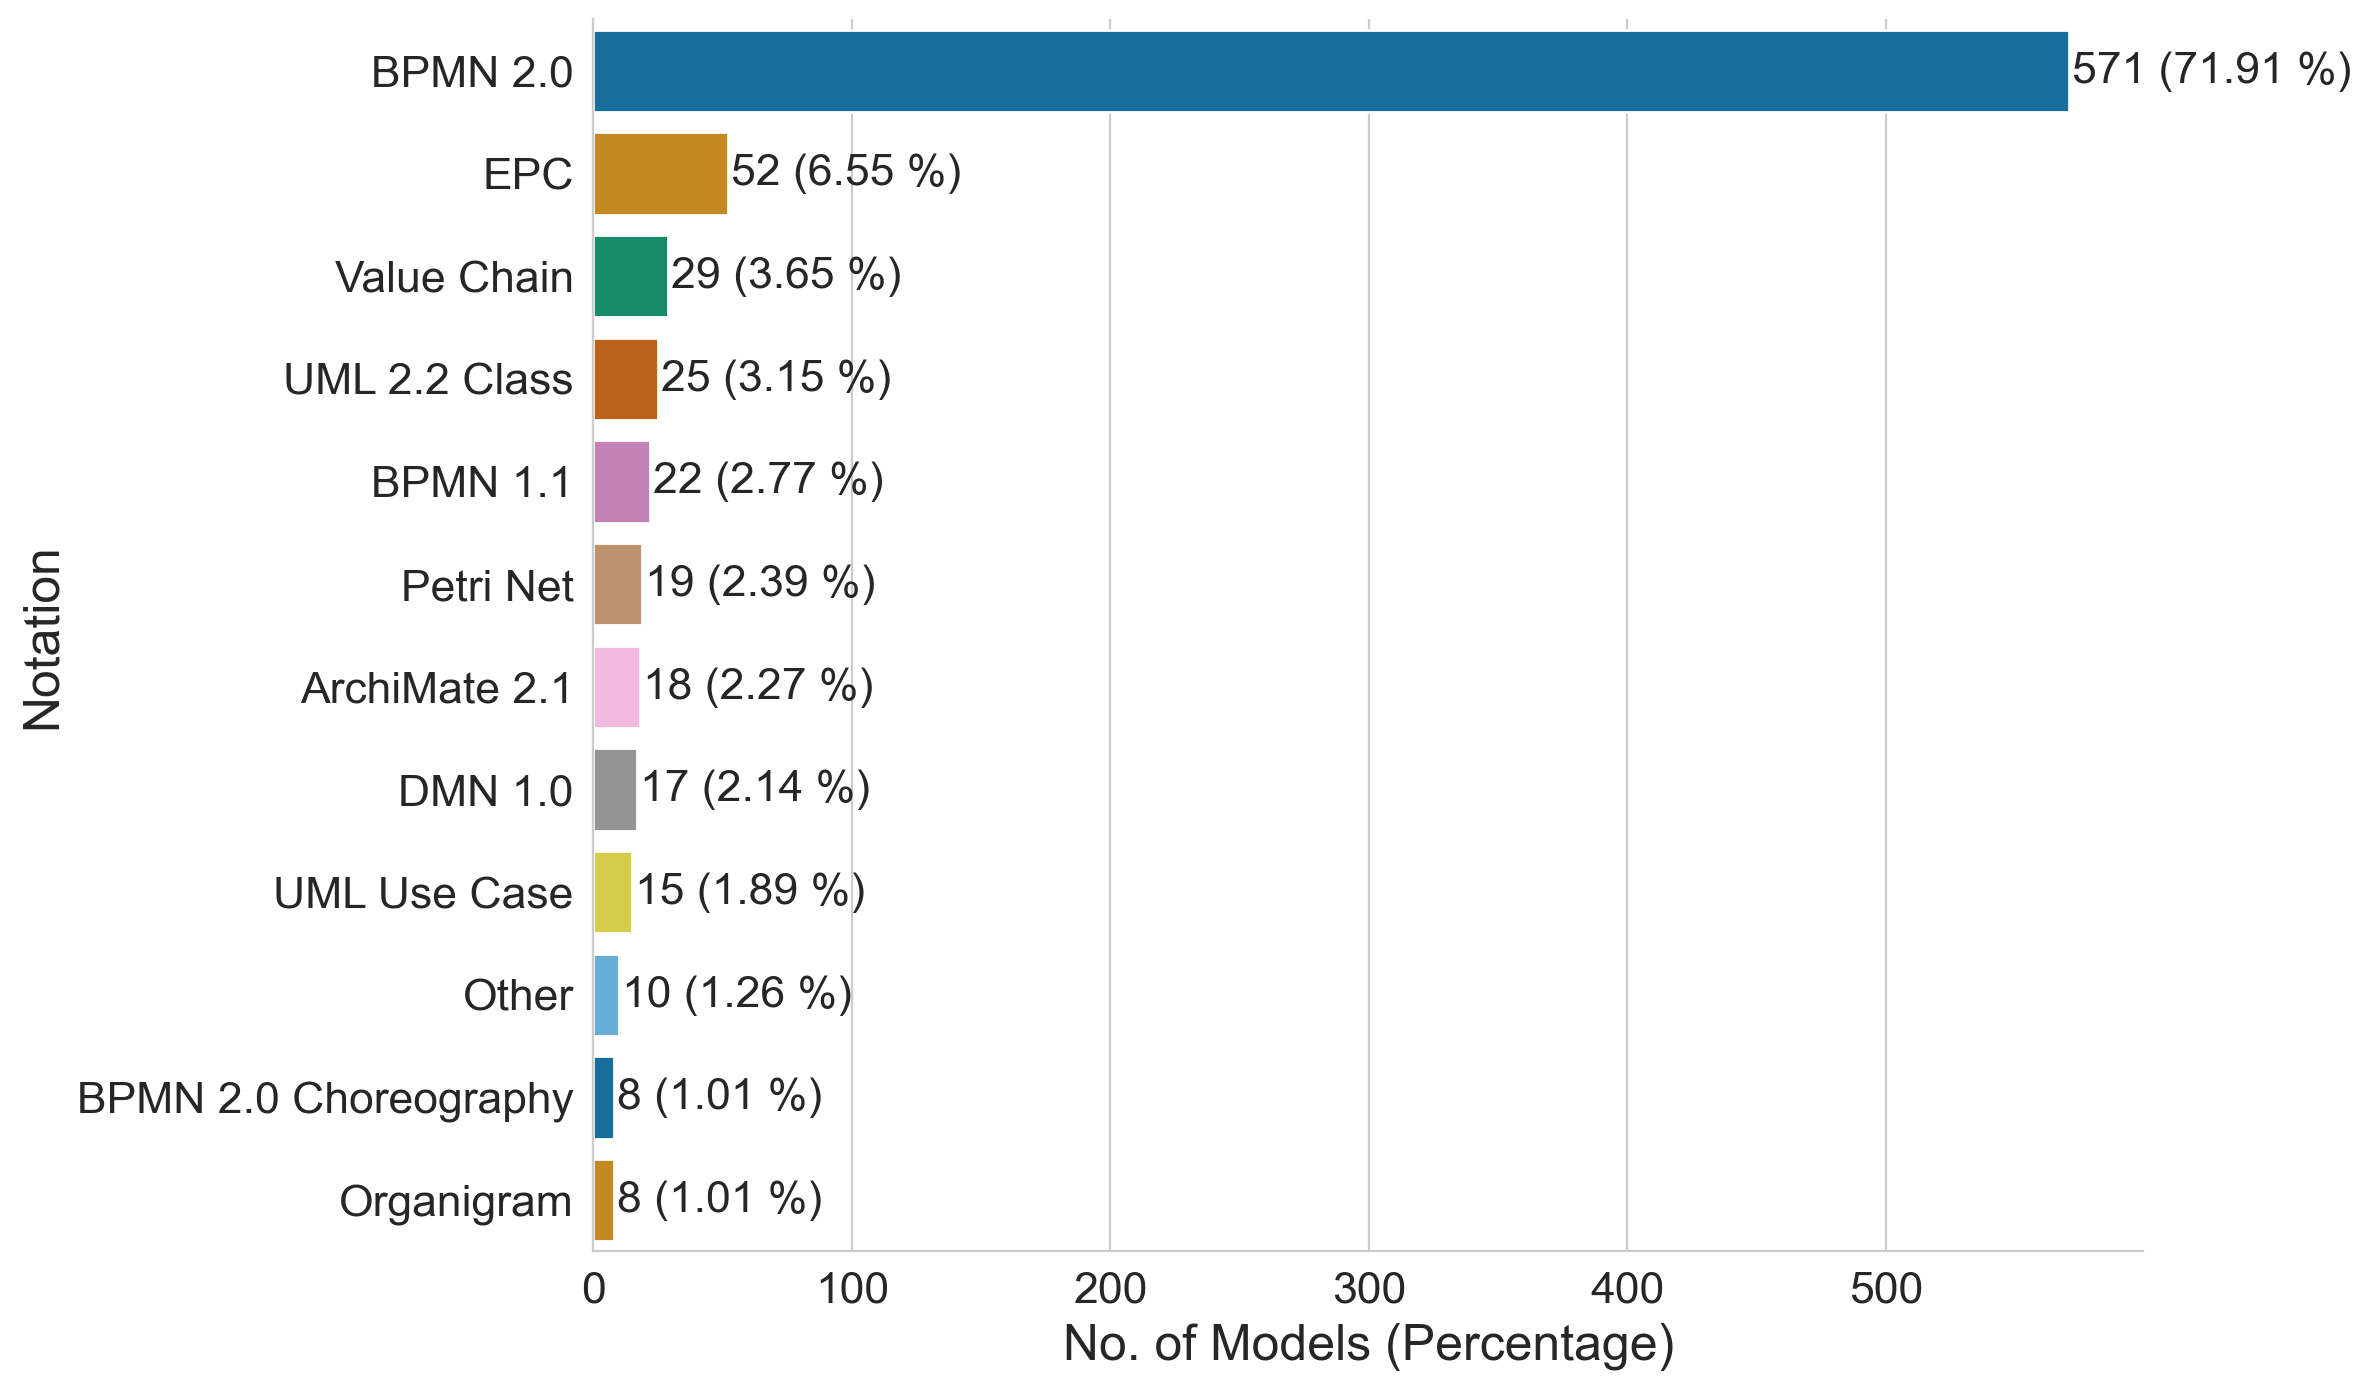

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
containers_nb = df_notations['Notation'].nunique()
ax=sns.barplot(x="Frequency",y="Notation",hue="Notation",data=df_notations,estimator = np.max, errorbar=('ci', 0),palette = sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
labels = [f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
sns.despine()
#ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
c326b827f8ea40f2ae8ddf2c7b79af06  f88df30ddac041ae824a90e2220cfa8b   

                                                   organization_id  \
model_id                                                             
c326b827f8ea40f2ae8ddf2c7b79af06  39bc11ff8b99481b91a3d3f16543c5c7   

                                            datetime  description  \
model_id                                                            
c326b827f8ea40f2ae8ddf2c7b79af06 2015-10-14 14:13:19          NaN   

                                         name type  \
model_id                                             
c326b827f8ea40f2ae8ddf2c7b79af06  New Diagram  NaN   

                                                             namespace  
model_id                                                                
c326b827f8ea40f2ae8ddf2c7b79af06  http://b3mn.org/stencilset/petrinet#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
c32c4d43c1a3473d8db670c3739bbb97  b72919cca2154cb5aba499254e0bd2b1   

                                                   organization_id  \
model_id                                                             
c32c4d43c1a3473d8db670c3739bbb97  8f45cdba3d7c4c1b814f1ab1a883e289   

                                            datetime  description  \
model_id                                                            
c32c4d43c1a3473d8db670c3739bbb97 2021-09-22 02:56:10          NaN   

                                            name type  \
model_id                                                
c32c4d43c1a3473d8db670c3739bbb97  LABORATORIO 6B  NaN   

                                                            namespace  
model_id                                                               
c32c4d43c1a3473d8db670c3739bbb97  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [21]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#        571
1                  http://b3mn.org/stencilset/epc#         52
2  http://www.signavio.com/stencilsets/processmap#         29
3          http://b3mn.org/stencilset/UML2.2Class#         25
4              http://b3mn.org/stencilset/bpmn1.1#         22

In [22]:
# handling the case where we have unknown namespaces in the dataset
# to inspect the unknown namespaces, comment the following line out:
#print(df_meta['namespace'].value_counts())
namespaces = mappings['namespaces'].keys()
df_meta['namespace'] = df_meta['namespace'].apply(lambda x: x if x in namespaces else 'Unknown')

In [23]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [24]:
df_meta_selected = df_meta_selected.groupby('namespace',observed=False).resample('YE').sum(numeric_only=True,min_count=1)
df_meta_selected = df_meta_selected['Count'].fillna(0)
df_meta_selected = df_meta_selected.reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [25]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0, observed=False)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class    0.0  2015
1  UML 2.2 Class    3.0  2016
2  UML 2.2 Class    2.0  2017
3  UML 2.2 Class    2.0  2018
4  UML 2.2 Class    1.0  2019

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [26]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

0

In [27]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2024]
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class    0.0  2015
1  UML 2.2 Class    3.0  2016
2  UML 2.2 Class    2.0  2017
3  UML 2.2 Class    2.0  2018
4  UML 2.2 Class    1.0  2019

In [28]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

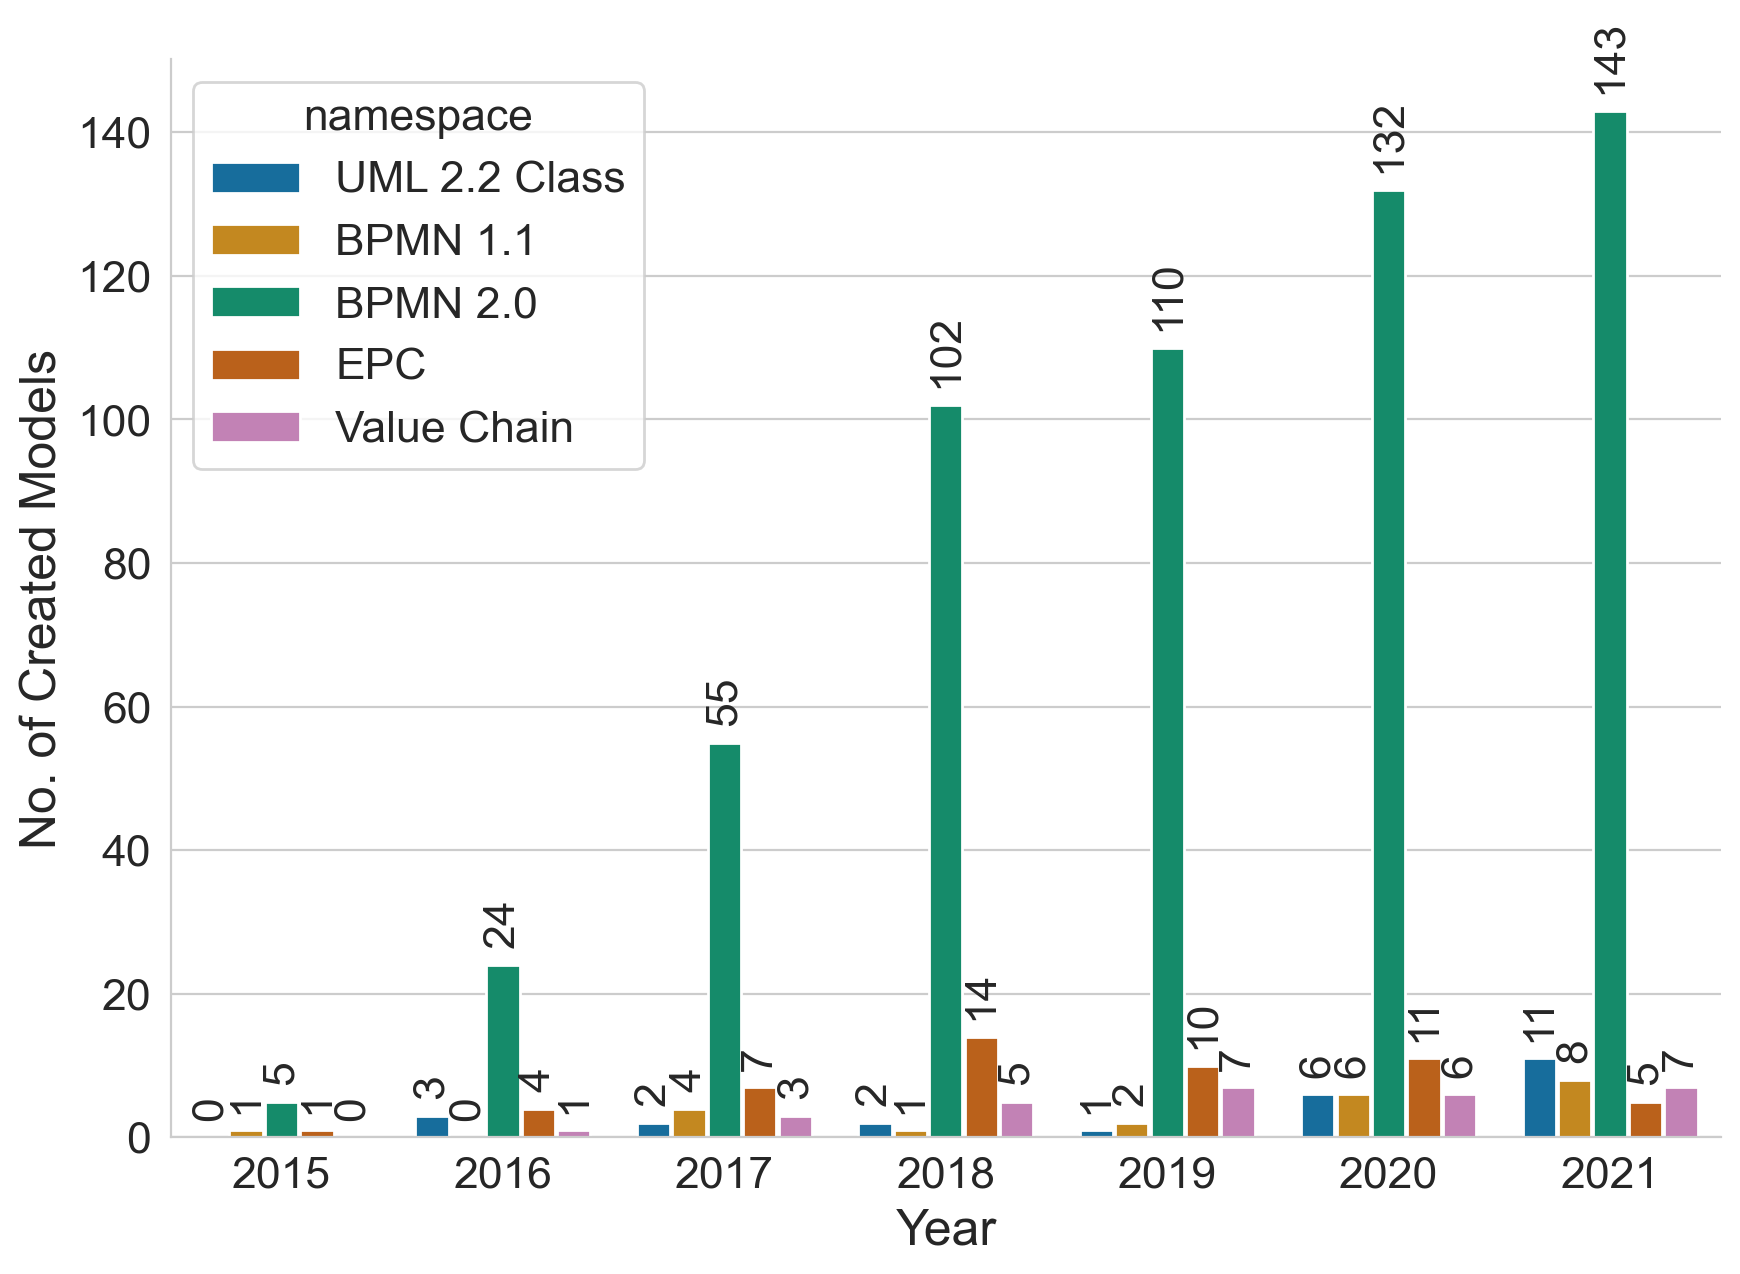

In [29]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax)
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [30]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0   EPC  Value Chain  UML 2.2 Class  BPMN 1.1
2021     143.0   5.0          7.0           11.0       8.0
2020     132.0  11.0          6.0            6.0       6.0
2019     110.0  10.0          7.0            1.0       2.0
2018     102.0  14.0          5.0            2.0       1.0
2017      55.0   7.0          3.0            2.0       4.0
2016      24.0   4.0          1.0            3.0       0.0
2015       5.0   1.0          0.0            0.0       1.0

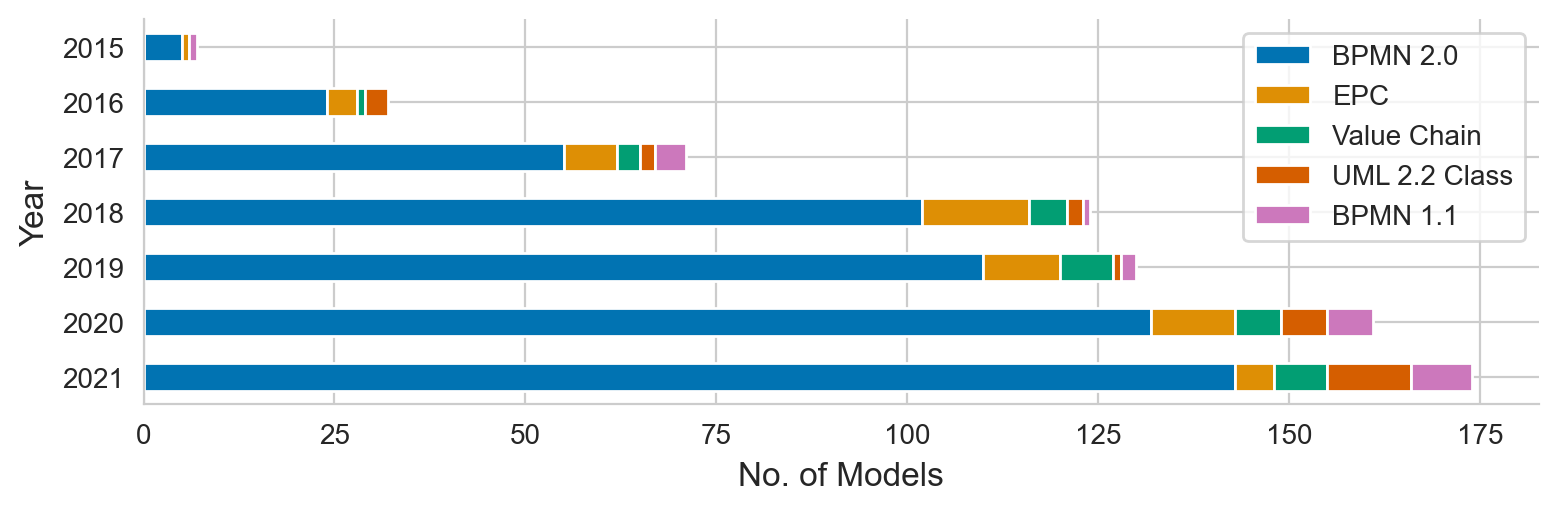

In [31]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [32]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
c30cf9af3ea04ff291d124c2ebe92eae  fe6d8b3a5e88472eb4ce60dc8ca53728   
c30d40f793534888825230949035cc4d  c64a40a2148745e68967f2a418c729b0   
c30d45bba7a64042b3e28e0858a5c5ce  9b06ab24a3b44d91ad883bdc6c18fbb2   
c30d5d5523434bb9845ac151b5523936  4f69714d921f4f799bcd2d1ae64f8b06   
c30da9fe000c497692deab32592140cd  678aaa899be049b9bf0adb69523ac6e8   

                                                   organization_id  \
model_id                                                             
c30cf9af3ea04ff291d124c2ebe92eae  a7236502a8574beba6cdaaf976b63a9c   
c30d40f793534888825230949035cc4d  b872fc9ec5ff482e8814b3644752d69d   
c30d45bba7a64042b3e28e0858a5c5ce  748451bbc4e6482c84fcc589ee6ca464   
c30d5d5523434bb9845ac151b5523936  39bc11ff8b99481b91a3d3f16543c5c7   
c30da9fe000c497692deab32592140cd  176cb1b58a18462196add0465476e5a2   

                                            datetime  description  \
model_id                                                            
c30cf9af3ea04ff291d124c2ebe92eae 2017-09-08 04:24:02          NaN   
c30d40f793534888825230949035cc4d 2018-06-04 16:34:25          NaN   
c30d45bba7a64042b3e28e0858a5c5ce 2019-03-01 21:01:41          NaN   
c30d5d5523434bb9845ac151b5523936 2015-11-06 09:30:40          NaN   
c30da9fe000c497692deab32592140cd 2020-05-16 11:54:15          NaN   

                                                                        name  \
model_id                                                                       
c30cf9af3ea04ff291d124c2ebe92eae  Phase 3: Application Documentation (1.1.1)   
c30d40f793534888825230949035cc4d                 Individual 2 long&amp;short   
c30d45bba7a64042b3e28e0858a5c5ce                Definir acciones comerciales   
c30d5d5523434bb9845ac151b5523936                   Academic verification (1)   
c30da9fe000c497692deab32592140cd            Auftrags-Personalplanungsprozess   

                                      type  \
model_id                                     
c30cf9af3ea04ff291d124c2ebe92eae       NaN   
c30d40f793534888825230949035cc4d       NaN   
c30d45bba7a64042b3e28e0858a5c5ce       NaN   
c30d5d5523434bb9845ac151b5523936  BPMN 2.0   
c30da9fe000c497692deab32592140cd       NaN   

                                                            namespace  
model_id                                                               
c30cf9af3ea04ff291d124c2ebe92eae  http://b3mn.org/stencilset/bpmn2.0#  
c30d40f793534888825230949035cc4d  http://b3mn.org/stencilset/bpmn2.0#  
c30d45bba7a64042b3e28e0858a5c5ce  http://b3mn.org/stencilset/bpmn2.0#  
c30d5d5523434bb9845ac151b5523936  http://b3mn.org/stencilset/bpmn2.0#  
c30da9fe000c497692deab32592140cd  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [33]:
len(df_meta_bpmn)

571

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [34]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


category  \
model_id                         element_id                                                             
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0                SequenceFlow   
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4  Association_Unidirectional   
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5  Association_Unidirectional   
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B                SequenceFlow   
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67                SequenceFlow   

                                                                                                label  \
model_id                         element_id                                                             
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0                               
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4                        None   
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5                        None   
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B                               
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67  Loan documents not correct   

                                                                          glossary_link_id  \
model_id                         element_id                                                  
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0             None   
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4             None   
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5             None   
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B             None   
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67             None   

                                                                                                                 name  
model_id                         element_id                                                                            
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0  Phase 3: Application Documentation (1.1.1)  
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4  Phase 3: Application Documentation (1.1.1)  
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5  Phase 3: Application Documentation (1.1.1)  
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B  Phase 3: Application Documentation (1.1.1)  
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67  Phase 3: Application Documentation (1.1.1)

Number of BPMN 2.0 models from the parser:

In [35]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

857

Number of BPMN 2.0 models from the parser after filtering out example processes, models with less than 5 elements, and models with no task, start event or end event elements:

In [36]:
df_bpmn = DataFilter(df_bpmn).filter_data("example_processes_bpmn")
df_bpmn = DataFilter(df_bpmn).filter_data("models", 5)

Filtering out example processes models...
Keeping 546 out of 857 from the dataset
Dataset has been filtered down to 546 models, a decrease of 36.29%.

Filtering out models with less than 5 elements...
Keeping 538 out of 546 from the dataset
Filtering out models with no start, end, or task elements...
Keeping 501 out of 538 from the dataset

Dataset has been filtered down to 501 models, a decrease of 8.24%.


When compared to the analysis of the dataset metadata, we notice that after the example processes filtering, the count of BPMN 2.0 models is slightly lower. This difference shows there are some empty BPMN 2.0 models in the dataset, which do not contain any elements and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [37]:
len(df_bpmn)

27904

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [38]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...
✓ Download and installation successful


In [39]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:08<00:00, 59.71it/s]


label  \
model_id                                                                              
c30cf9af3ea04ff291d124c2ebe92eae   Loan documents not correct Loan documents Rev...   
c30d40f793534888825230949035cc4d  Branch A Short-term Branch B Long-term  Medica...   
c30d45bba7a64042b3e28e0858a5c5ce   Generar el factor de impacto diario estimado ...   
c30d5d5523434bb9845ac151b5523936   Academic degrees [assessed] Academic degrees ...   
c30da9fe000c497692deab32592140cd   Projektplanung\nüberarbeiten Capacity-Forecas...   

                                                                        name  \
model_id                                                                       
c30cf9af3ea04ff291d124c2ebe92eae  Phase 3: Application Documentation (1.1.1)   
c30d40f793534888825230949035cc4d                 Individual 2 long&amp;short   
c30d45bba7a64042b3e28e0858a5c5ce                Definir acciones comerciales   
c30d5d5523434bb9845ac151b5523936                   Academic verification (1)   
c30da9fe000c497692deab32592140cd            Auftrags-Personalplanungsprozess   

                                 detected_natural_language  
model_id                                                    
c30cf9af3ea04ff291d124c2ebe92eae                        en  
c30d40f793534888825230949035cc4d                        en  
c30d45bba7a64042b3e28e0858a5c5ce                        es  
c30d5d5523434bb9845ac151b5523936                        en  
c30da9fe000c497692deab32592140cd                        de

Let's plot the use of different languages across the dataset.

In [40]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [41]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                    English            243
1                     German            127
2                    Italian             30
3                    Spanish             29
4                     French             11
5                   Croatian             10
6                      Dutch              9
7                 Portuguese              7
8                   Romanian              6
9                    Swedish              6
10                  Estonian              6
11                 Slovenian              5
12                Indonesian              3
13                   Catalan              2
14                     Welsh              2
15                    Polish              1
16                 Norwegian              1
17  Unknown language [zh-cn]              1
18                   Finnish              1
19                  Albanian              1

We only plot the 10 most common languages.

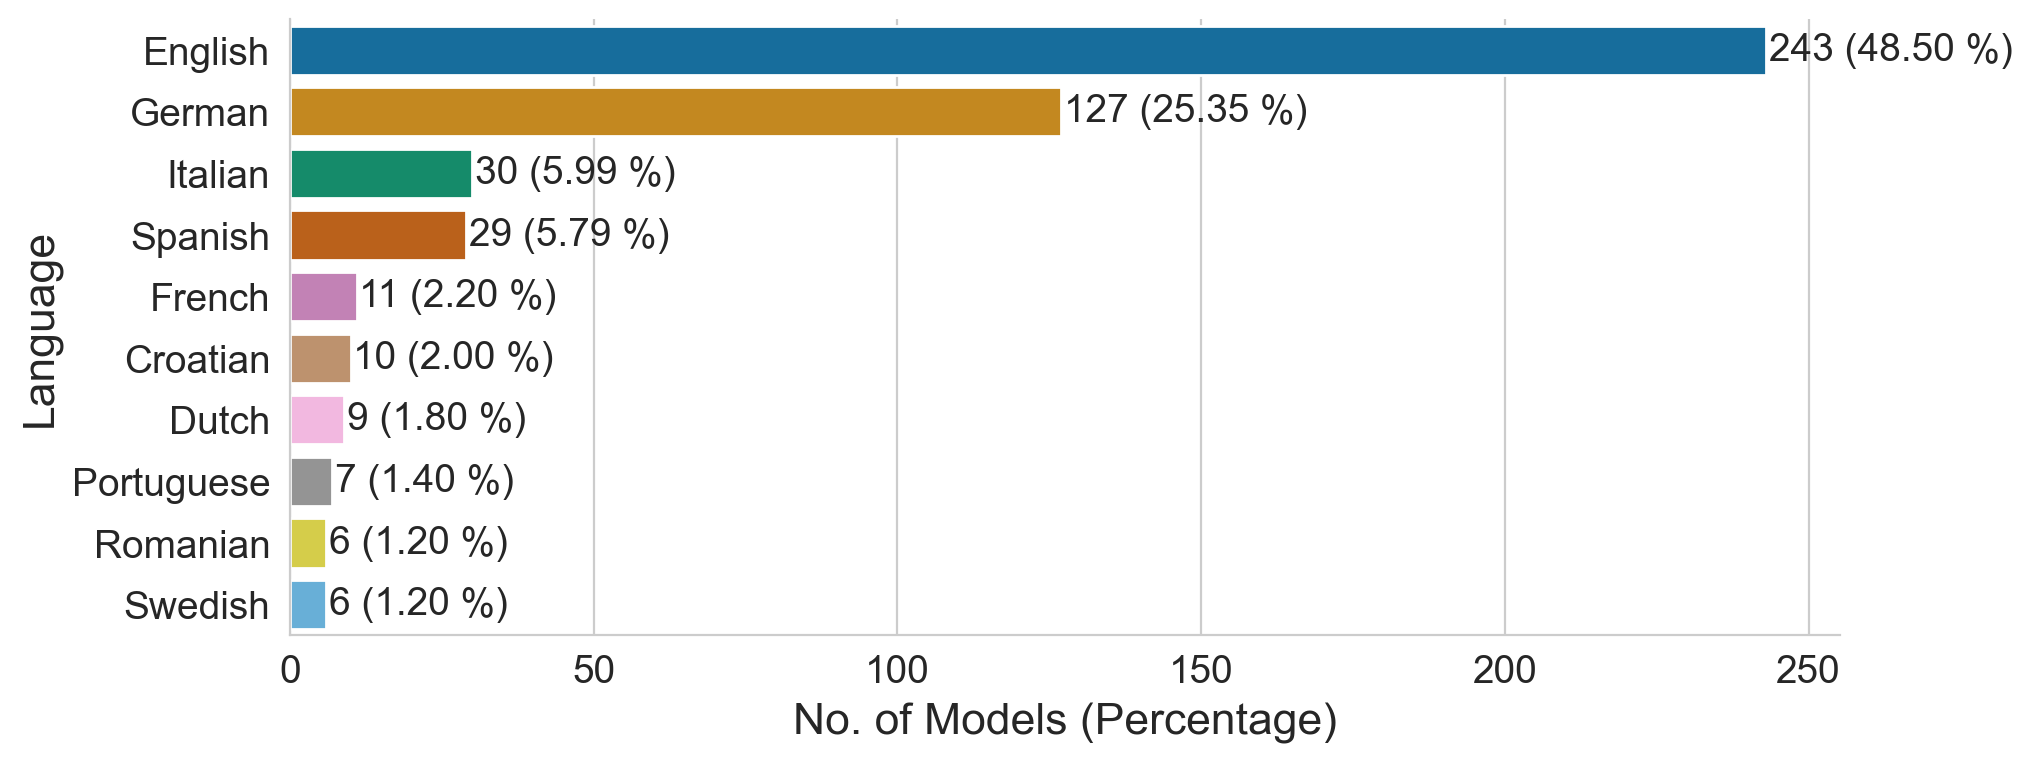

In [42]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", hue="Language", data=df_lang)
labels = [f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=1, labels=[label])
#ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=)
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [43]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [44]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0).convert_dtypes() # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 4119.19it/s]


SequenceFlow  Association_Unidirectional  MessageFlow  Pool  Lane  \
0            24                           2            3     3     3   
1            35                           0            0     1     6   
2             5                           0            0     0     0   
3             9                           2            3     2     2   
4             8                           2            4     1     2   

   IntermediateMessageEventCatching  IntermediateTimerEvent  EndMessageEvent  \
0                                 2                       3                1   
1                                 3                       1                0   
2                                 0                       0                0   
3                                 0                       0                0   
4                                 0                       0                1   

   Exclusive_Databased_Gateway  Task  StartMessageEvent  \
0                            6     6                  1   
1                            8    14                  2   
2                            0     4                  0   
3                            0     5                  0   
4                            2     1                  1   

   IntermediateLinkEventThrowing  DataObject  \
0                              1           1   
1                              0           0   
2                              0           0   
3                              0           3   
4                              0           0   

   IntermediateMessageEventThrowing  StartNoneEvent  total_count  \
0                                 1               1           58   
1                                 0               0           77   
2                                 0               1           11   
3                                 0               1           30   
4                                 0               0           32   

   EndNoneEvent  EventSubprocess  EventbasedGateway  ParallelGateway  \
0             0                0                  0                0   
1             5                1                  1                0   
2             1                0                  0                0   
3             1                0                  0                2   
4             1                0                  0                0   

   DataStore  Message  CollapsedPool  IntermediateCancelEvent  \
0          0        0              0                        0   
1          0        0              0                        0   
2          0        0              0                        0   
3          0        0              0                        0   
4          1        4              2                        1   

   CollapsedSubprocess  Association_Undirected  TextAnnotation  \
0                    0                       0               0   
1                    0                       0               0   
2                    0                       0               0   
3                    0                       0               0   
4                    1                       0               0   

   processparticipant  Subprocess  CollapsedVerticalPool  VerticalPool  \
0                   0           0                      0             0   
1                   0           0                      0             0   
2                   0           0                      0             0   
3                   0           0                      0             0   
4                   0           0                      0             0   

   VerticalLane  EndErrorEvent  InclusiveGateway  ITSystem  EndCancelEvent  \
0             0              0                 0         0               0   
1             0              0                 0         0               0   
2             0              0                 0         0               0   
3             0              0                 0         0

These are the statistics of the different element types per model:

In [45]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count        501.0
mean     10.373253
std       4.080981
min            4.0
25%            7.0
50%           10.0
75%           13.0
max           26.0
dtype: Float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [46]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0)
    .convert_dtypes()
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
c30cf9af3ea04ff291d124c2ebe92eae                          0   
c30d40f793534888825230949035cc4d                          0   
c30d45bba7a64042b3e28e0858a5c5ce                          0   
c30d5d5523434bb9845ac151b5523936                          0   
c30da9fe000c497692deab32592140cd                          0   

category                          Association_Undirected  \
model_id                                                   
c30cf9af3ea04ff291d124c2ebe92eae                       0   
c30d40f793534888825230949035cc4d                       0   
c30d45bba7a64042b3e28e0858a5c5ce                       0   
c30d5d5523434bb9845ac151b5523936                       0   
c30da9fe000c497692deab32592140cd                       0   

category                          Association_Unidirectional  CollapsedPool  \
model_id                                                                      
c30cf9af3ea04ff291d124c2ebe92eae                           2              0   
c30d40f793534888825230949035cc4d                           0              0   
c30d45bba7a64042b3e28e0858a5c5ce                           0              0   
c30d5d5523434bb9845ac151b5523936                           2              0   
c30da9fe000c497692deab32592140cd                           2              2   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
c30cf9af3ea04ff291d124c2ebe92eae                    0                      0   
c30d40f793534888825230949035cc4d                    0                      0   
c30d45bba7a64042b3e28e0858a5c5ce                    0                      0   
c30d5d5523434bb9845ac151b5523936                    0                      0   
c30da9fe000c497692deab32592140cd                    1                      0   

category                          ComplexGateway  DataObject  DataStore  \
model_id                                                                  
c30cf9af3ea04ff291d124c2ebe92eae               0           1          0   
c30d40f793534888825230949035cc4d               0           0          0   
c30d45bba7a64042b3e28e0858a5c5ce               0           0          0   
c30d5d5523434bb9845ac151b5523936               0           3          0   
c30da9fe000c497692deab32592140cd               0           0          1   

category                          EndCancelEvent  EndErrorEvent  \
model_id                                                          
c30cf9af3ea04ff291d124c2ebe92eae               0              0   
c30d40f793534888825230949035cc4d               0              0   
c30d45bba7a64042b3e28e0858a5c5ce               0              0   
c30d5d5523434bb9845ac151b5523936               0              0   
c30da9fe000c497692deab32592140cd               0              0   

category                          EndEscalationEvent  EndMessageEvent  \
model_id                                                                
c30cf9af3ea04ff291d124c2ebe92eae                   0                1   
c30d40f793534888825230949035cc4d                   0                0   
c30d45bba7a64042b3e28e0858a5c5ce                   0                0   
c30d5d5523434bb9845ac151b5523936                   0                0   
c30da9fe000c497692deab32592140cd                   0                1   

category                          EndNoneEvent  EndSignalEvent  \
model_id                                                         
c30cf9af3ea04ff291d124c2ebe92eae             0               0   
c30d40f793534888825230949035cc4d             5               0   
c30d45bba7a64042b3e28e0858a5c5ce             1               0   
c30d5d5523434bb9845ac151b5523936             1               0   
c30da9fe000c497692deab32592140cd             1               0   

category                          EndTerminateEvent

In [47]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
df_freq[df_freq["frequency"]/len(df_cnts) < 0.1].head()

category  frequency
23        InclusiveGateway         42
24         StartTimerEvent         40
25              Subprocess         38
26       EndTerminateEvent         29
27  IntermediateErrorEvent         29

In [48]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).cat.rename_categories({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_26949/2467356405.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))


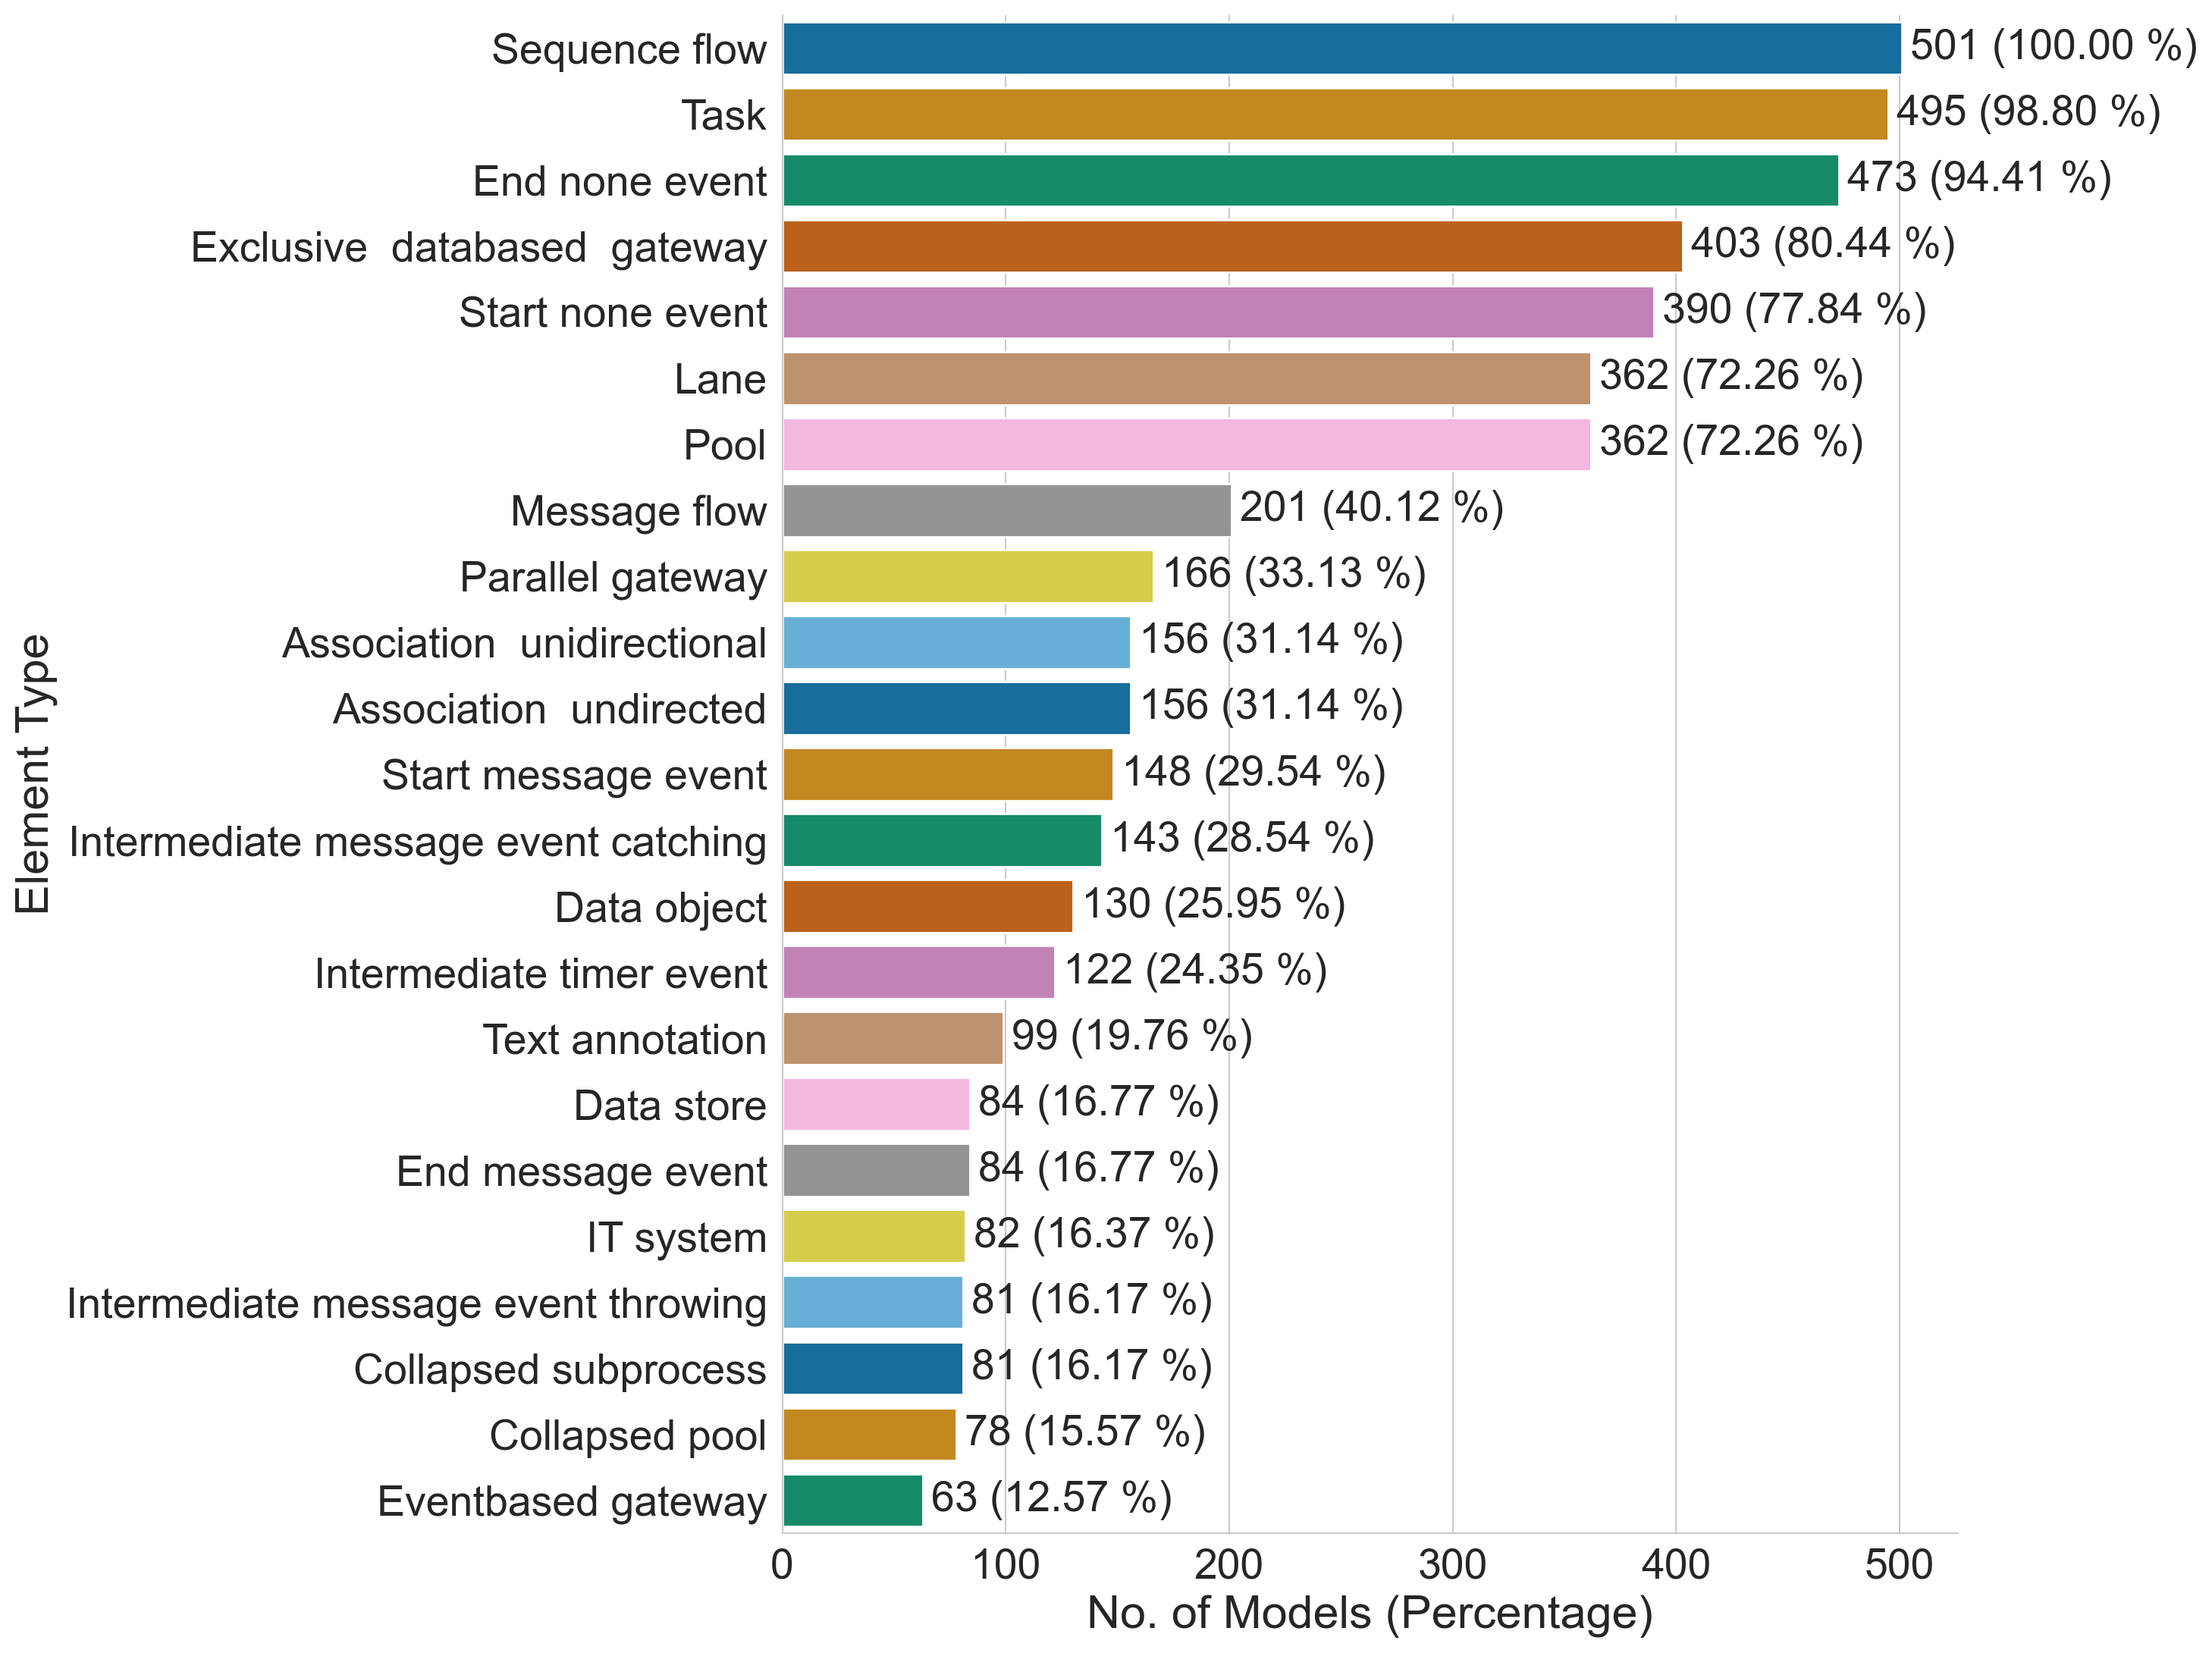

In [49]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
containers_nb = df_freq['category'].nunique()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown.
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.barplot(x="frequency", y="category",hue="category", legend=False, data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
else:
    ax = sns.barplot(x="frequency", y="category",data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind", n_colors=containers_nb))
total = len(df_cnts)
labels = [f'{val} ({val / total * 100.0:.2f} %)' for val in df_freq['frequency']]
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [50]:
df_bpmn.head()

category  \
model_id                         element_id                                                             
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0                SequenceFlow   
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4  Association_Unidirectional   
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5  Association_Unidirectional   
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B                SequenceFlow   
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67                SequenceFlow   

                                                                                                label  \
model_id                         element_id                                                             
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0                               
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4                        None   
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5                        None   
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B                               
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67  Loan documents not correct   

                                                                          glossary_link_id  \
model_id                         element_id                                                  
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0             None   
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4             None   
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5             None   
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B             None   
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67             None   

                                                                                                                 name  
model_id                         element_id                                                                            
c30cf9af3ea04ff291d124c2ebe92eae sid-90D2DDF1-8F9E-4075-8480-B64E94D818D0  Phase 3: Application Documentation (1.1.1)  
                                 sid-5DC0AA30-48EC-4821-A5D8-1052710B57D4  Phase 3: Application Documentation (1.1.1)  
                                 sid-591D1198-B389-4223-BA27-29AE505DA2A5  Phase 3: Application Documentation (1.1.1)  
                                 sid-FC36A365-029A-4CF3-B8EA-8DCEFEB5971B  Phase 3: Application Documentation (1.1.1)  
                                 sid-BD3B360E-BDAE-4D05-A706-3DBCA98D6C67  Phase 3: Application Documentation (1.1.1)

First, we calculate and visualize the total counts of business objects in the dataset.

In [51]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [52]:
total_bos_count = len(total_bos)
total_bos_count

147

In [53]:
len(df_bpmn)

27904

When compared to the total number of elements, that would be about:

In [54]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

0.53%


Next, let's take a look at how many models have at least one glossary link.

In [55]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [56]:
len(models_w_bos)

61

The highest number of glossary links used in one model:

In [57]:
models_w_bos.max()

20

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [58]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

130

In [59]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

88.44%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_26949/970890613.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))


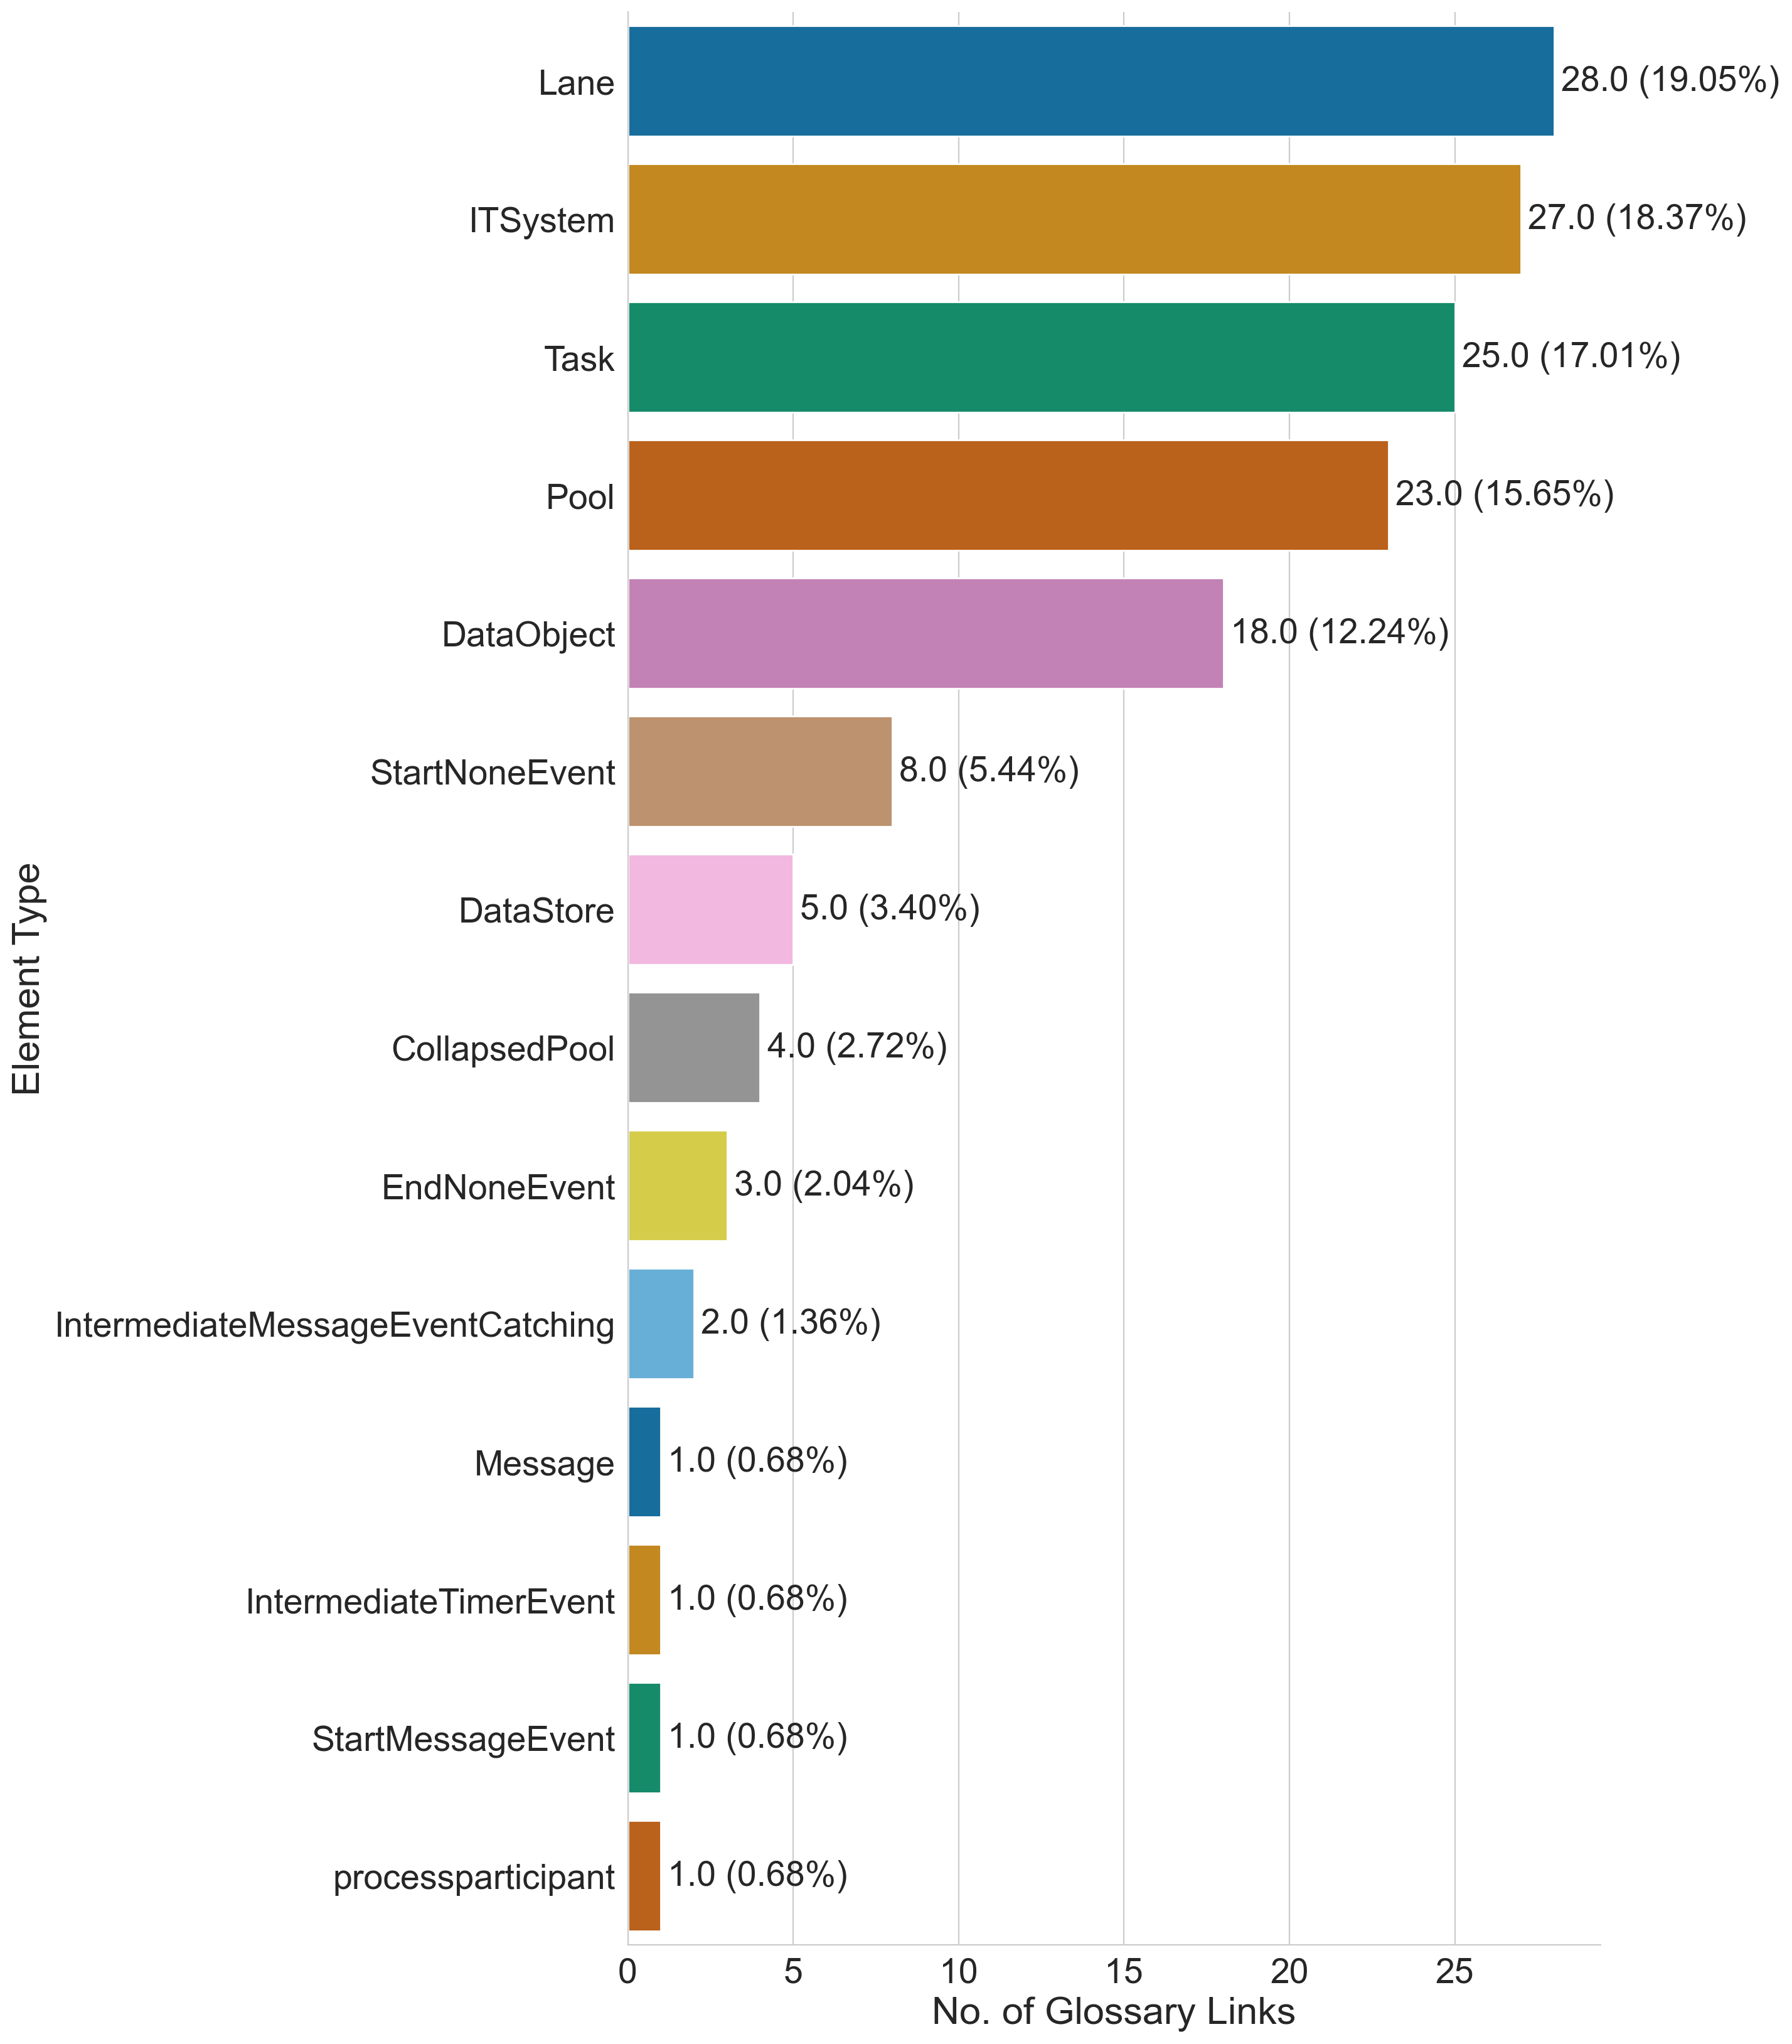

In [92]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
containers_nb = total_bos['category'].nunique()
total_bos.loc[:, 'category'] = total_bos['category'].cat.remove_unused_categories()
# for running analysis on smaller datasets, the hue setting must be omitted, otherwise graph won't be created.
# reason: number of containers represents the original overall count of categories (from the first dataframe), not the filtered/manipulated ones. As a result, more containers are being iterated over as should be.
# thoroughly investigated and origin of problem currently unknown.
if len(df_meta_bpmn) > 4000: # arbitrary value
    ax = sns.countplot(y="category", hue="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb),legend=False)
else:
    ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind", n_colors=containers_nb))
labels = []
for container in ax.containers:
    for val in container:
        labels.append(f'{val.get_width()} ({val.get_width()/total_bos_count*100.0:.2f}%)')
for container, label in zip(ax.containers, labels):
    ax.bar_label(container, label_type='edge', padding=4, labels=[label])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particular category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [61]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [62]:
len(its_bos_count)

16

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [63]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

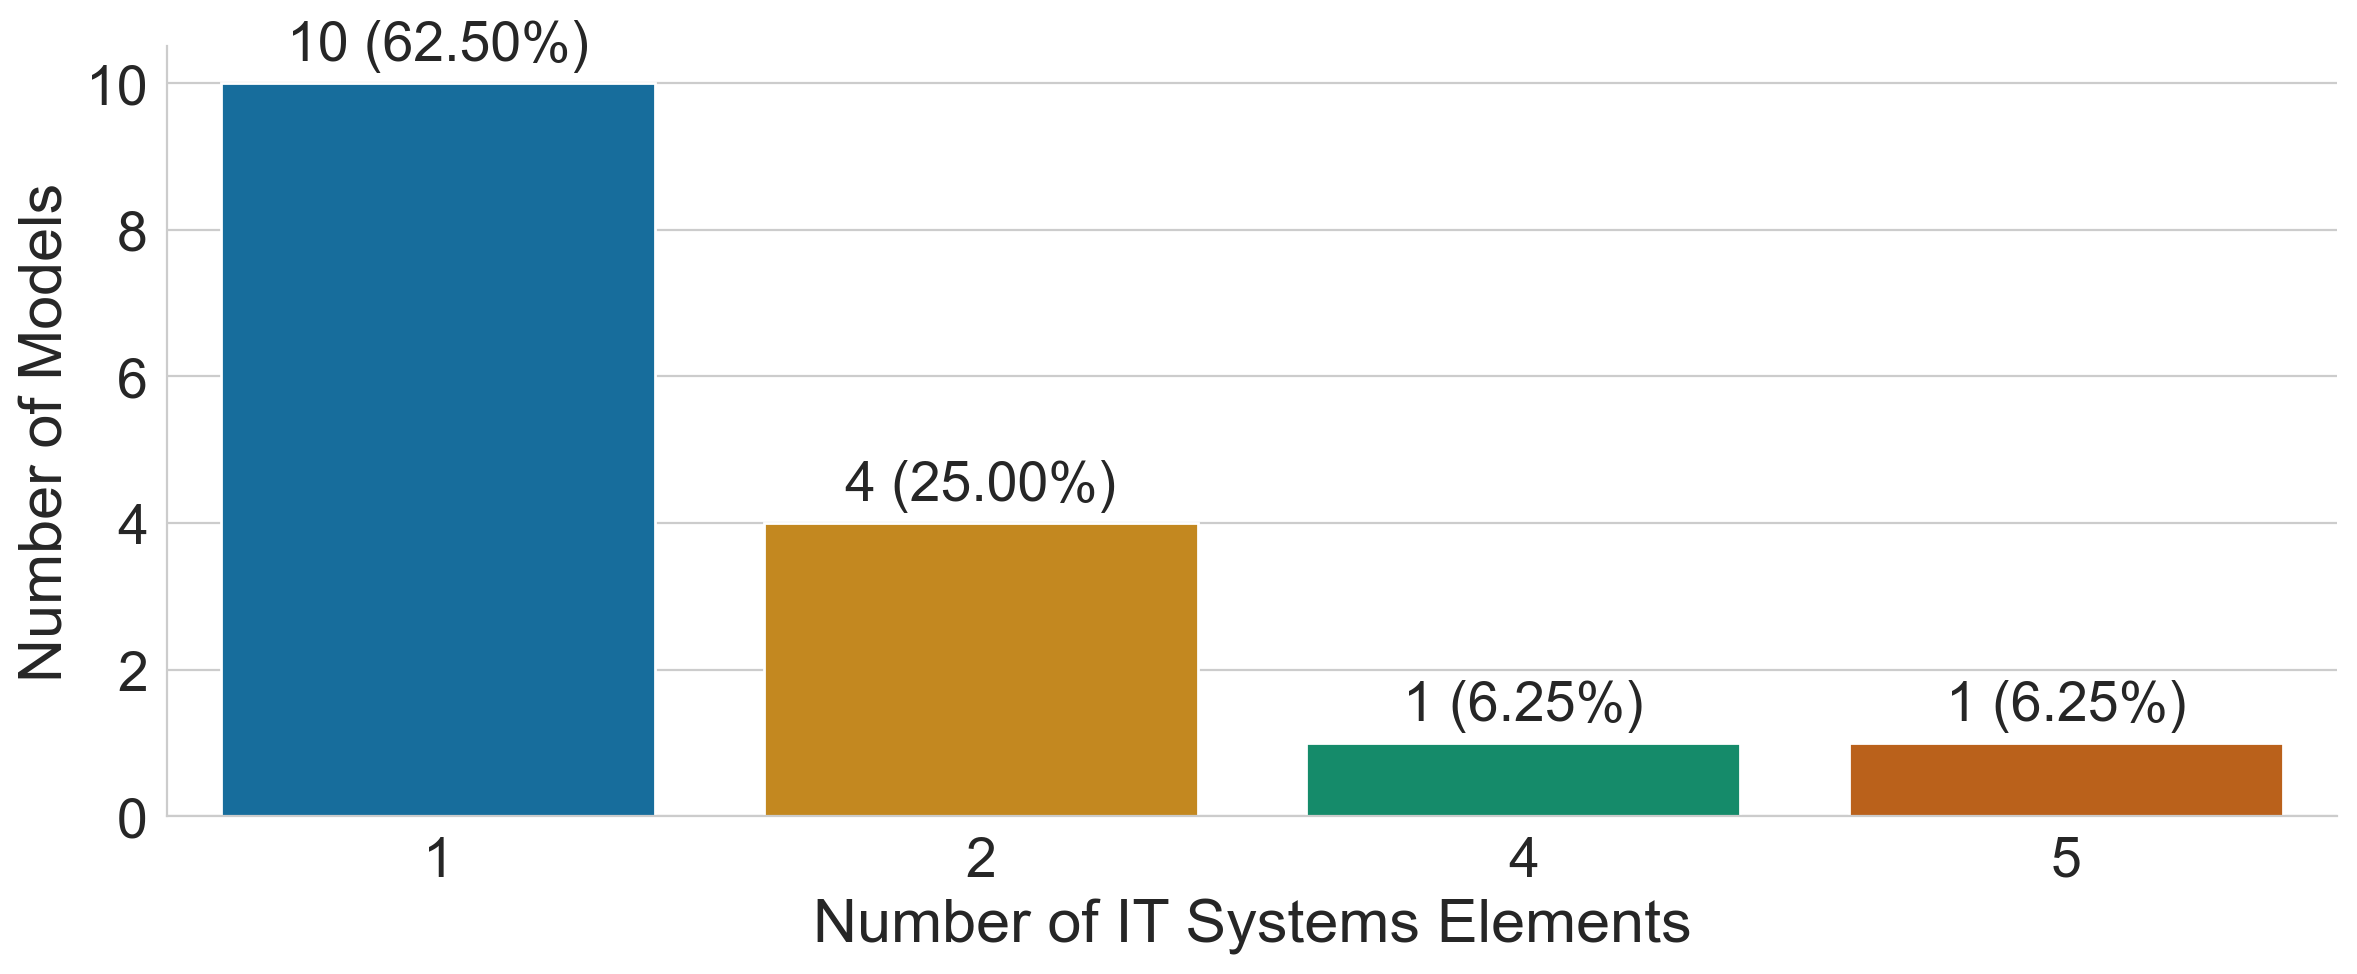

In [64]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos_count)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [65]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

glossary_link_id
1    14
2     1
4     1
Name: count, dtype: int64

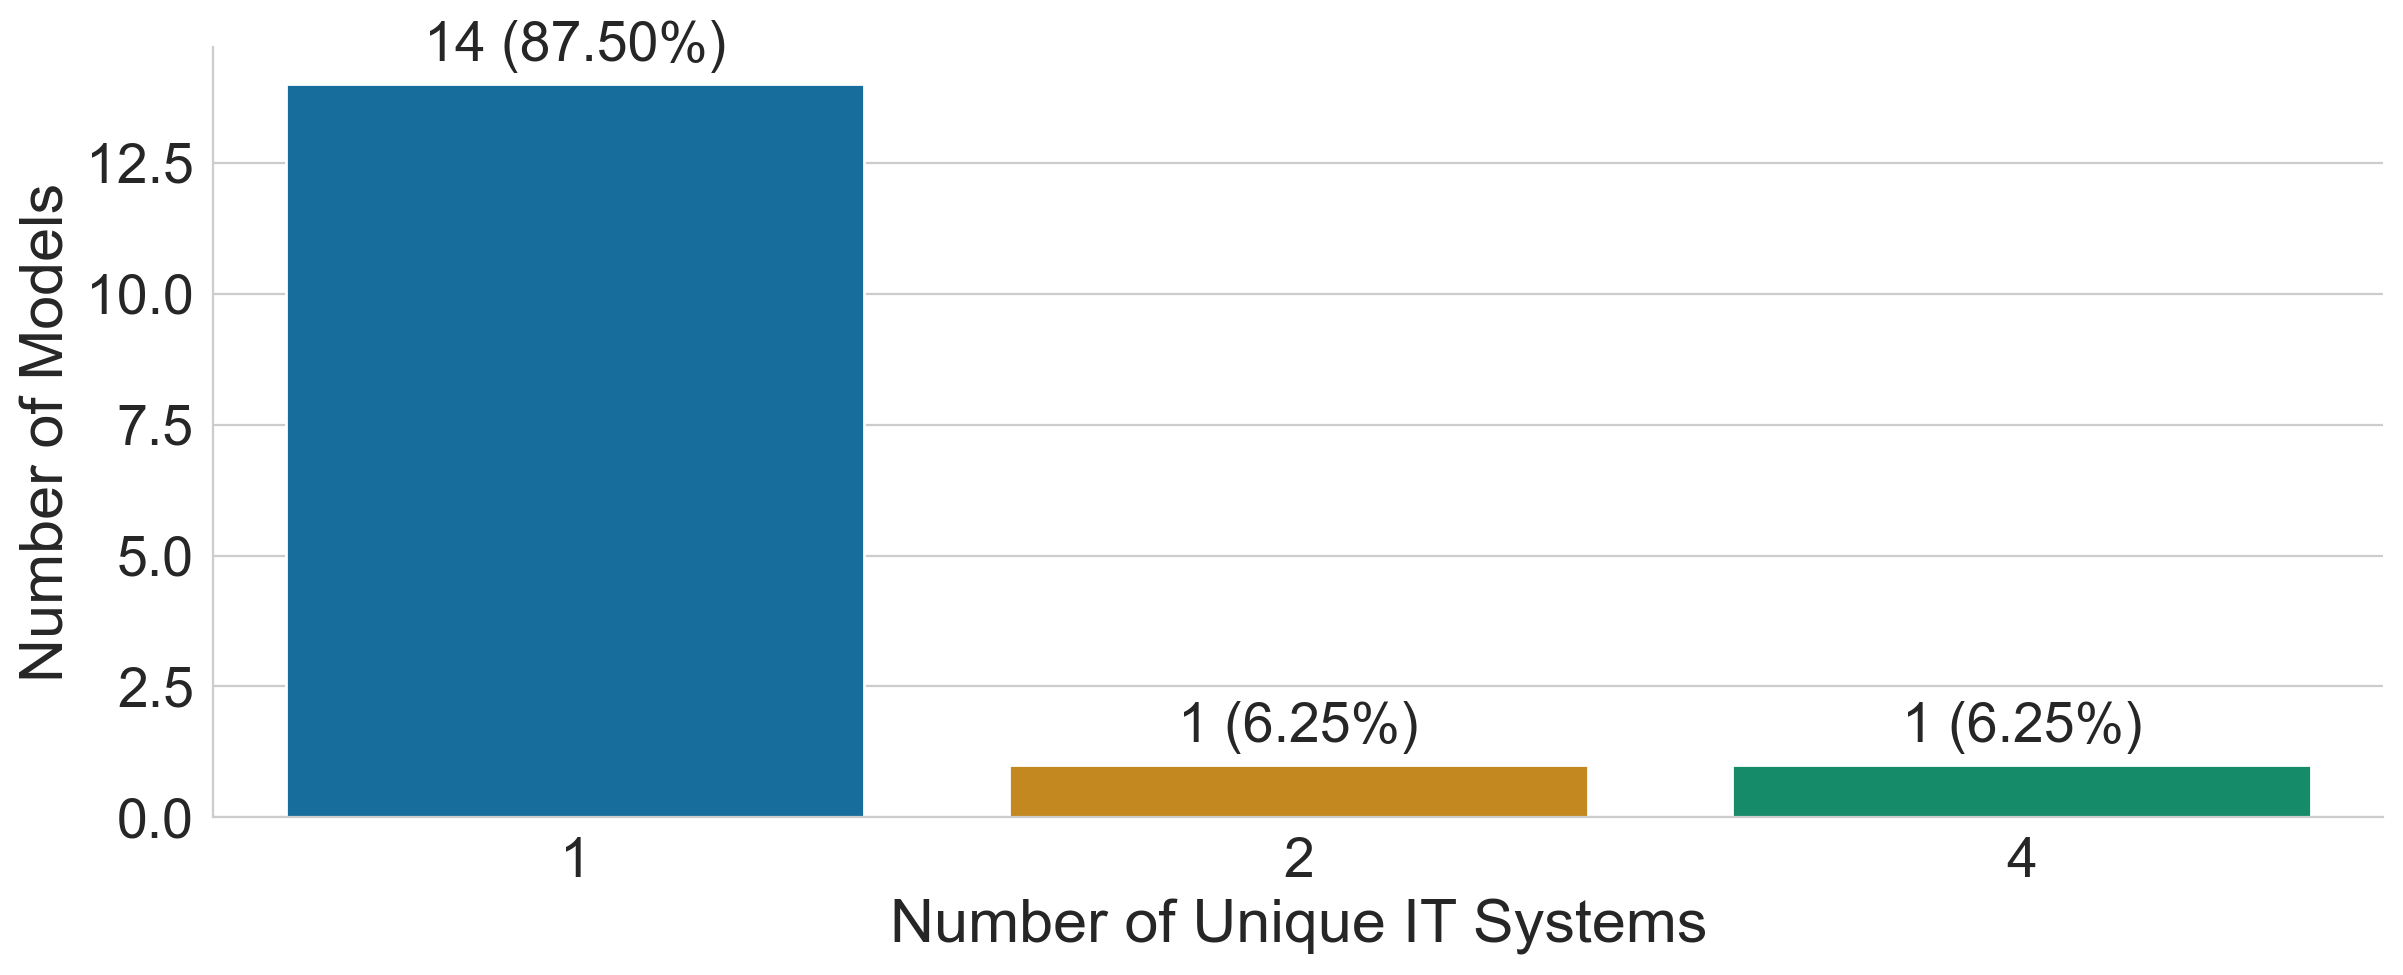

In [66]:
if len(its_bos_count) == 0:
    pass
else:
    plt.figure(figsize=(14, 5))
    containers_nb = its_count_per_model.index.nunique()
    ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,hue=its_count_per_model.index,palette=sns.color_palette("colorblind",n_colors=containers_nb),legend=False)
    total = len(its_bos)
    labels = [f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values]
    for container, label in zip(ax.containers, labels):
        ax.bar_label(container, label_type='edge', padding=4, labels=[label])
    sns.despine()
    ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
    ax.set_ylabel("Number of Models",fontsize=22)
    plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As expected, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [67]:
cnt_elements.total_count.describe()

count        501.0
mean     55.696607
std      60.563386
min            5.0
25%           25.0
50%           43.0
75%           67.0
max          946.0
Name: total_count, dtype: Float64

These are the statistics of the number of elements per model by element type:

In [68]:
cnt_elements.describe().transpose().head()

count      mean        std  min   25%   50%   75%  \
SequenceFlow                501.0   21.9002  21.020229  2.0  10.0  16.0  27.0   
Association_Unidirectional  501.0  2.075848   6.689263  0.0   0.0   0.0   2.0   
MessageFlow                 501.0  2.159681   3.844275  0.0   0.0   0.0   3.0   
Pool                        501.0  1.147705   1.051732  0.0   0.0   1.0   2.0   
Lane                        501.0  2.249501   2.105142  0.0   0.0   2.0   3.0   

                              max  
SequenceFlow                254.0  
Association_Unidirectional   98.0  
MessageFlow                  32.0  
Pool                          6.0  
Lane                         13.0

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [69]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [70]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_26949/2650037200.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()


count       mean        std  min   25%   50%   75%    max
Activities          501.0  10.686627   9.176906  1.0   5.0   9.0  13.0   79.0
Artifacts           501.0   1.297405   7.431916  0.0   0.0   0.0   1.0  155.0
Connecting Objects  501.0  27.610778  32.503572  2.0  11.0  20.0  33.0  507.0
Data Elements       501.0   1.746507   5.826286  0.0   0.0   0.0   1.0   98.0
Events              501.0   5.916168   6.293883  2.0   2.0   4.0   7.0   67.0
Gateways            501.0   4.728543   7.138219  0.0   2.0   3.0   6.0  122.0
Swimlanes           501.0   3.710579   3.109673  0.0   0.0   4.0   5.0   17.0

In [71]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%    max
Activities          10.7   9.2  1.0   5.0   9.0  13.0   79.0
Artifacts            1.3   7.4  0.0   0.0   0.0   1.0  155.0
Connecting Objects  27.6  32.5  2.0  11.0  20.0  33.0  507.0
Data Elements        1.7   5.8  0.0   0.0   0.0   1.0   98.0
Events               5.9   6.3  2.0   2.0   4.0   7.0   67.0
Gateways             4.7   7.1  0.0   2.0   3.0   6.0  122.0
Swimlanes            3.7   3.1  0.0   0.0   4.0   5.0   17.0

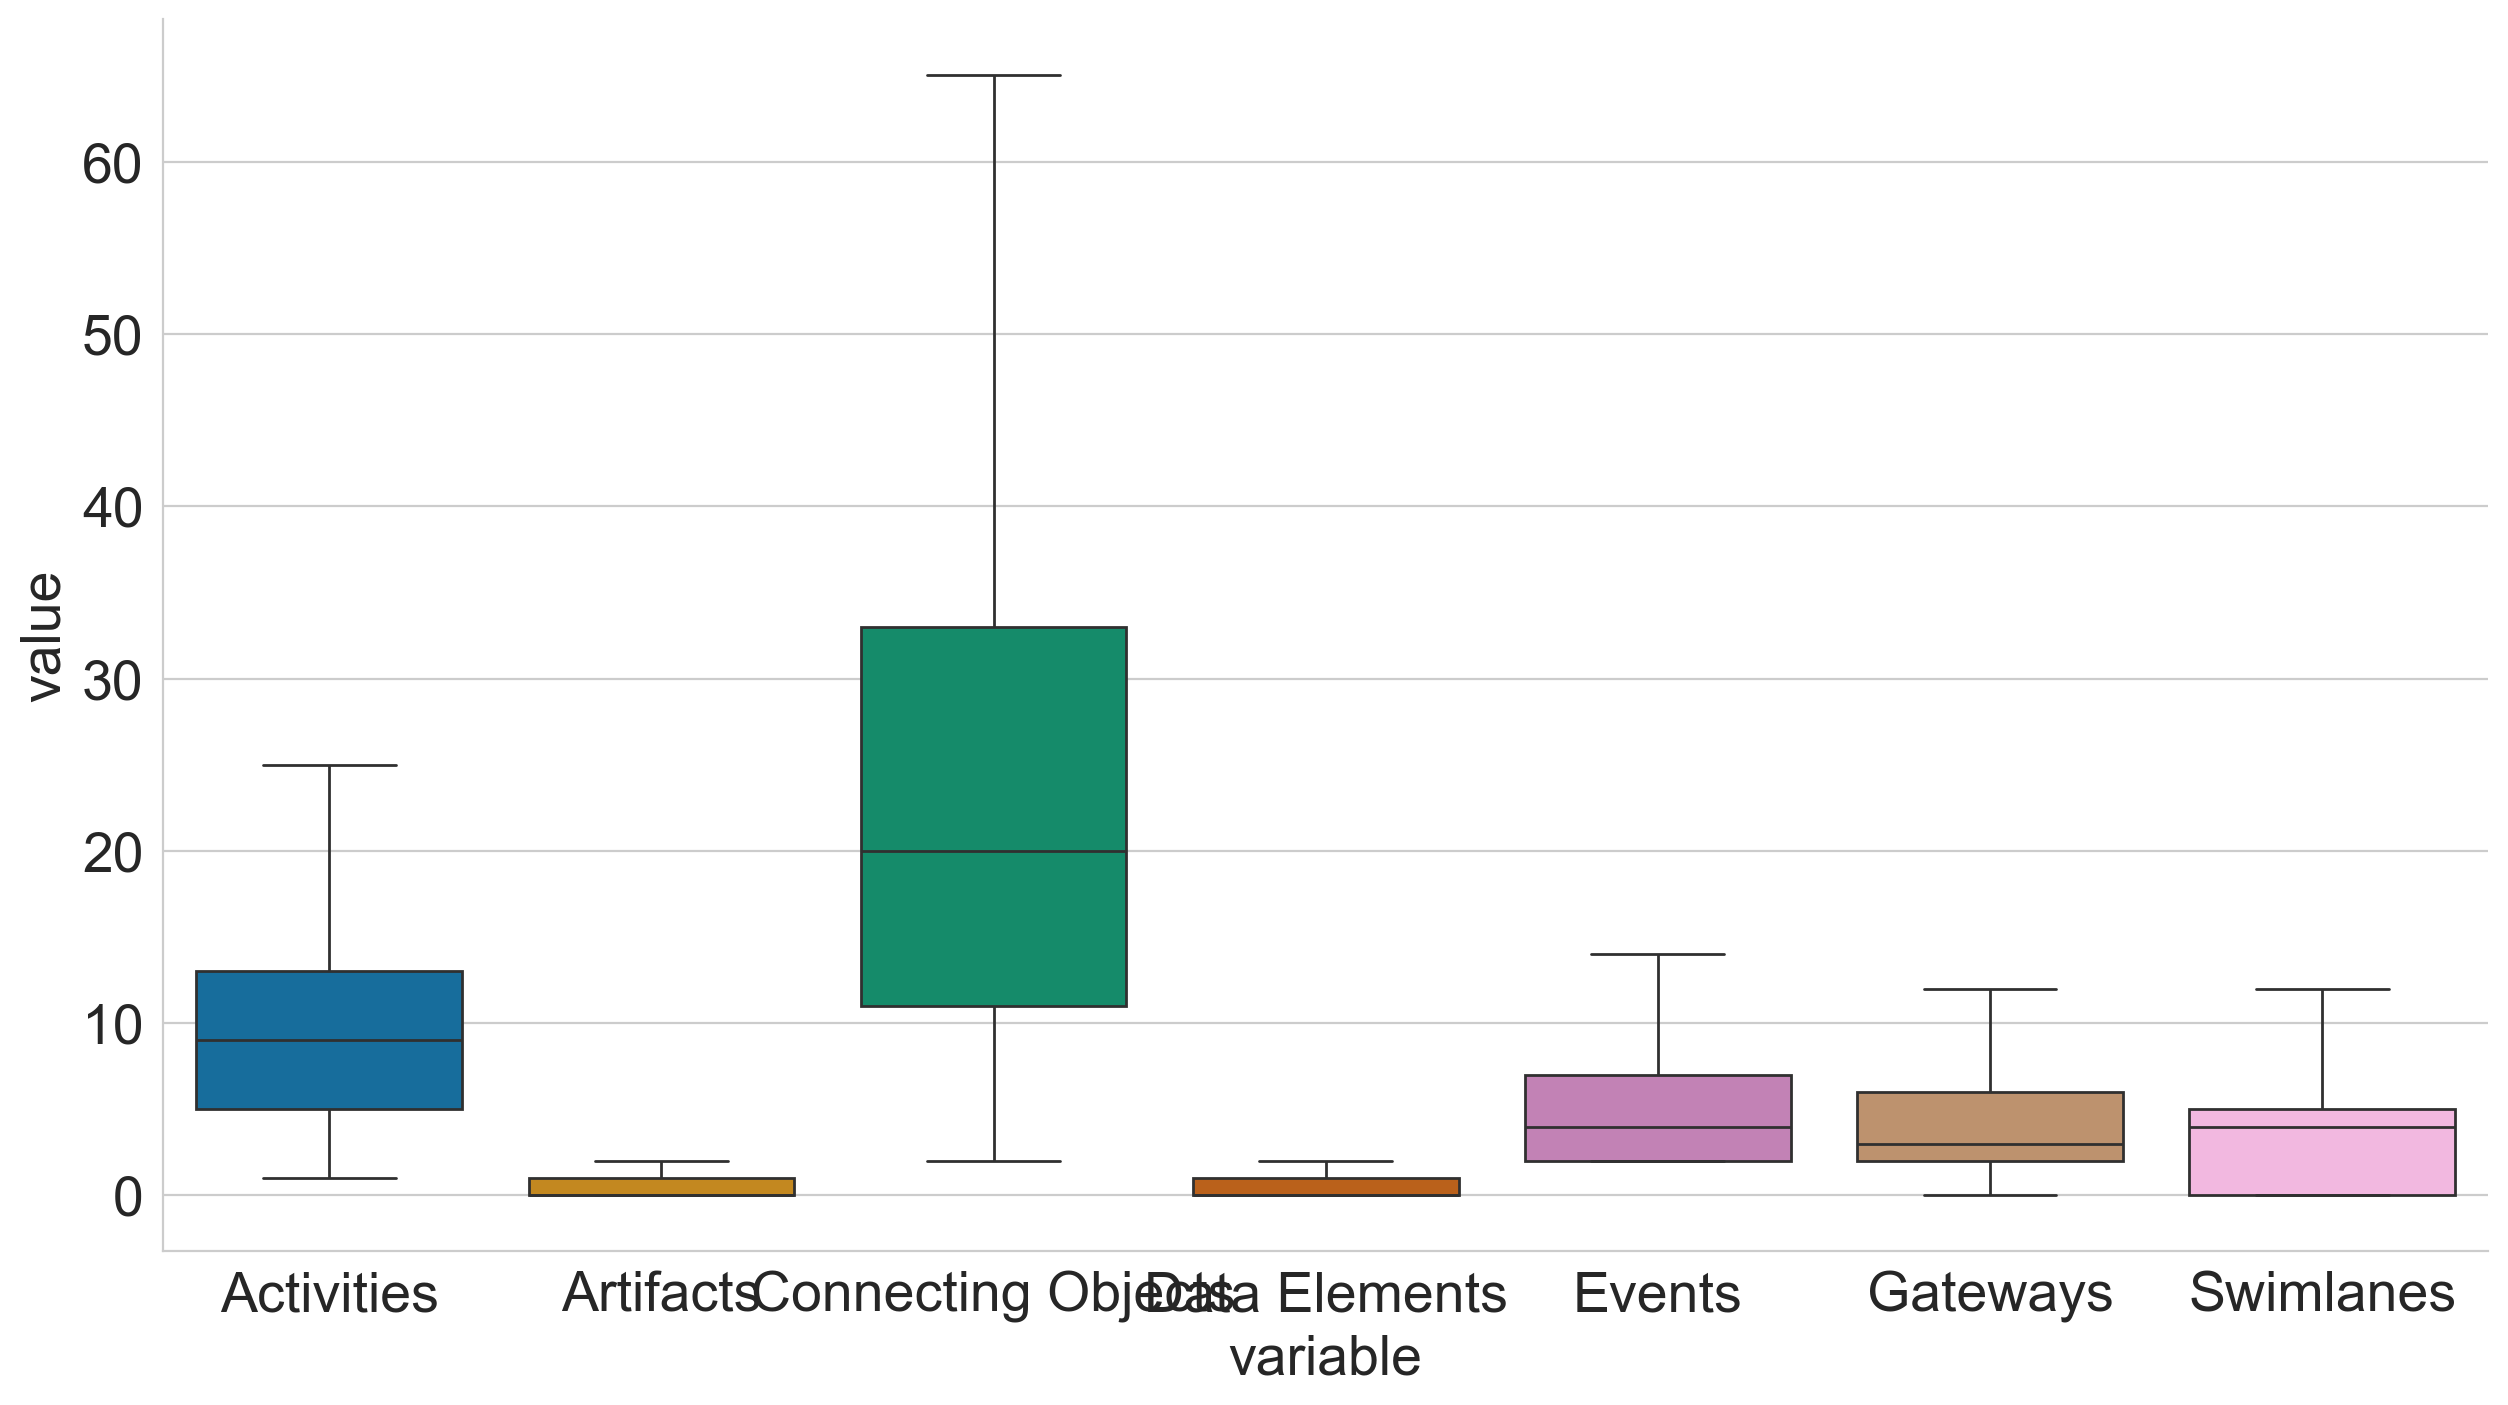

In [72]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", hue="variable", legend=False, data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind", n_colors=7))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [73]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

/var/folders/rn/8_jypvhj2jv1m35k5h8ygpyh0000gn/T/ipykernel_26949/1799829117.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()


count       mean        std  min   25%   50%   75%    max
No. of Edges  501.0  27.610778  32.503572  2.0  11.0  20.0  33.0  507.0
No. of Nodes  501.0  28.085828  28.258992  3.0  13.0  22.0  34.0  439.0

In [74]:
df_high_level.head()

No. of Edges  No. of Nodes
0            29            29
1            35            42
2             5             6
3            14            16
4            14            18

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

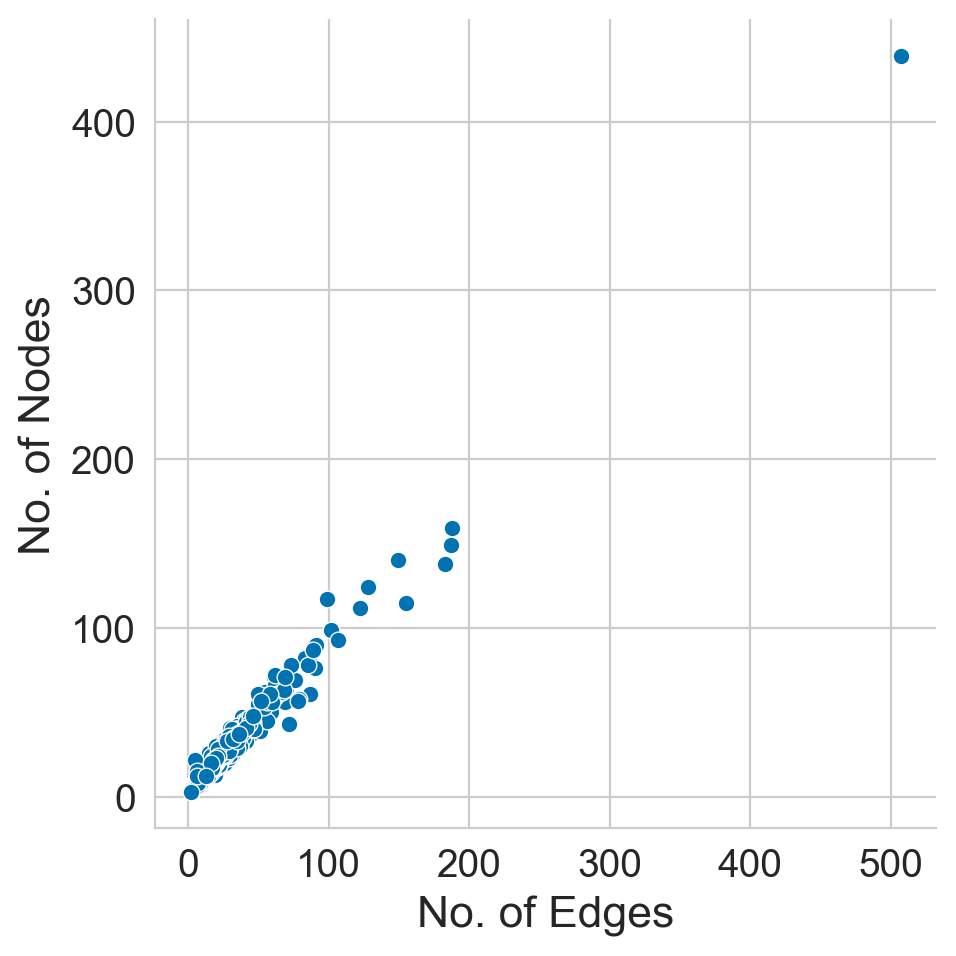

In [75]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
#plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.pdf',transparent=True,bbox_inches = 'tight')

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [76]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [77]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0              New Process           24
1                 12345678           23
2            Neuer Prozess            7
3                     BPMN            5
4                    Final            3
5            12345678_rev2            3
6  1.zadatak (Copy) (Copy)            2
7            12345678_rev5            2
8                       T2            2
9                     Test            2

The number of distinct process names:

In [78]:
len(cnts_names)

725

We use Signavio's color palette for the word cloud.

In [79]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

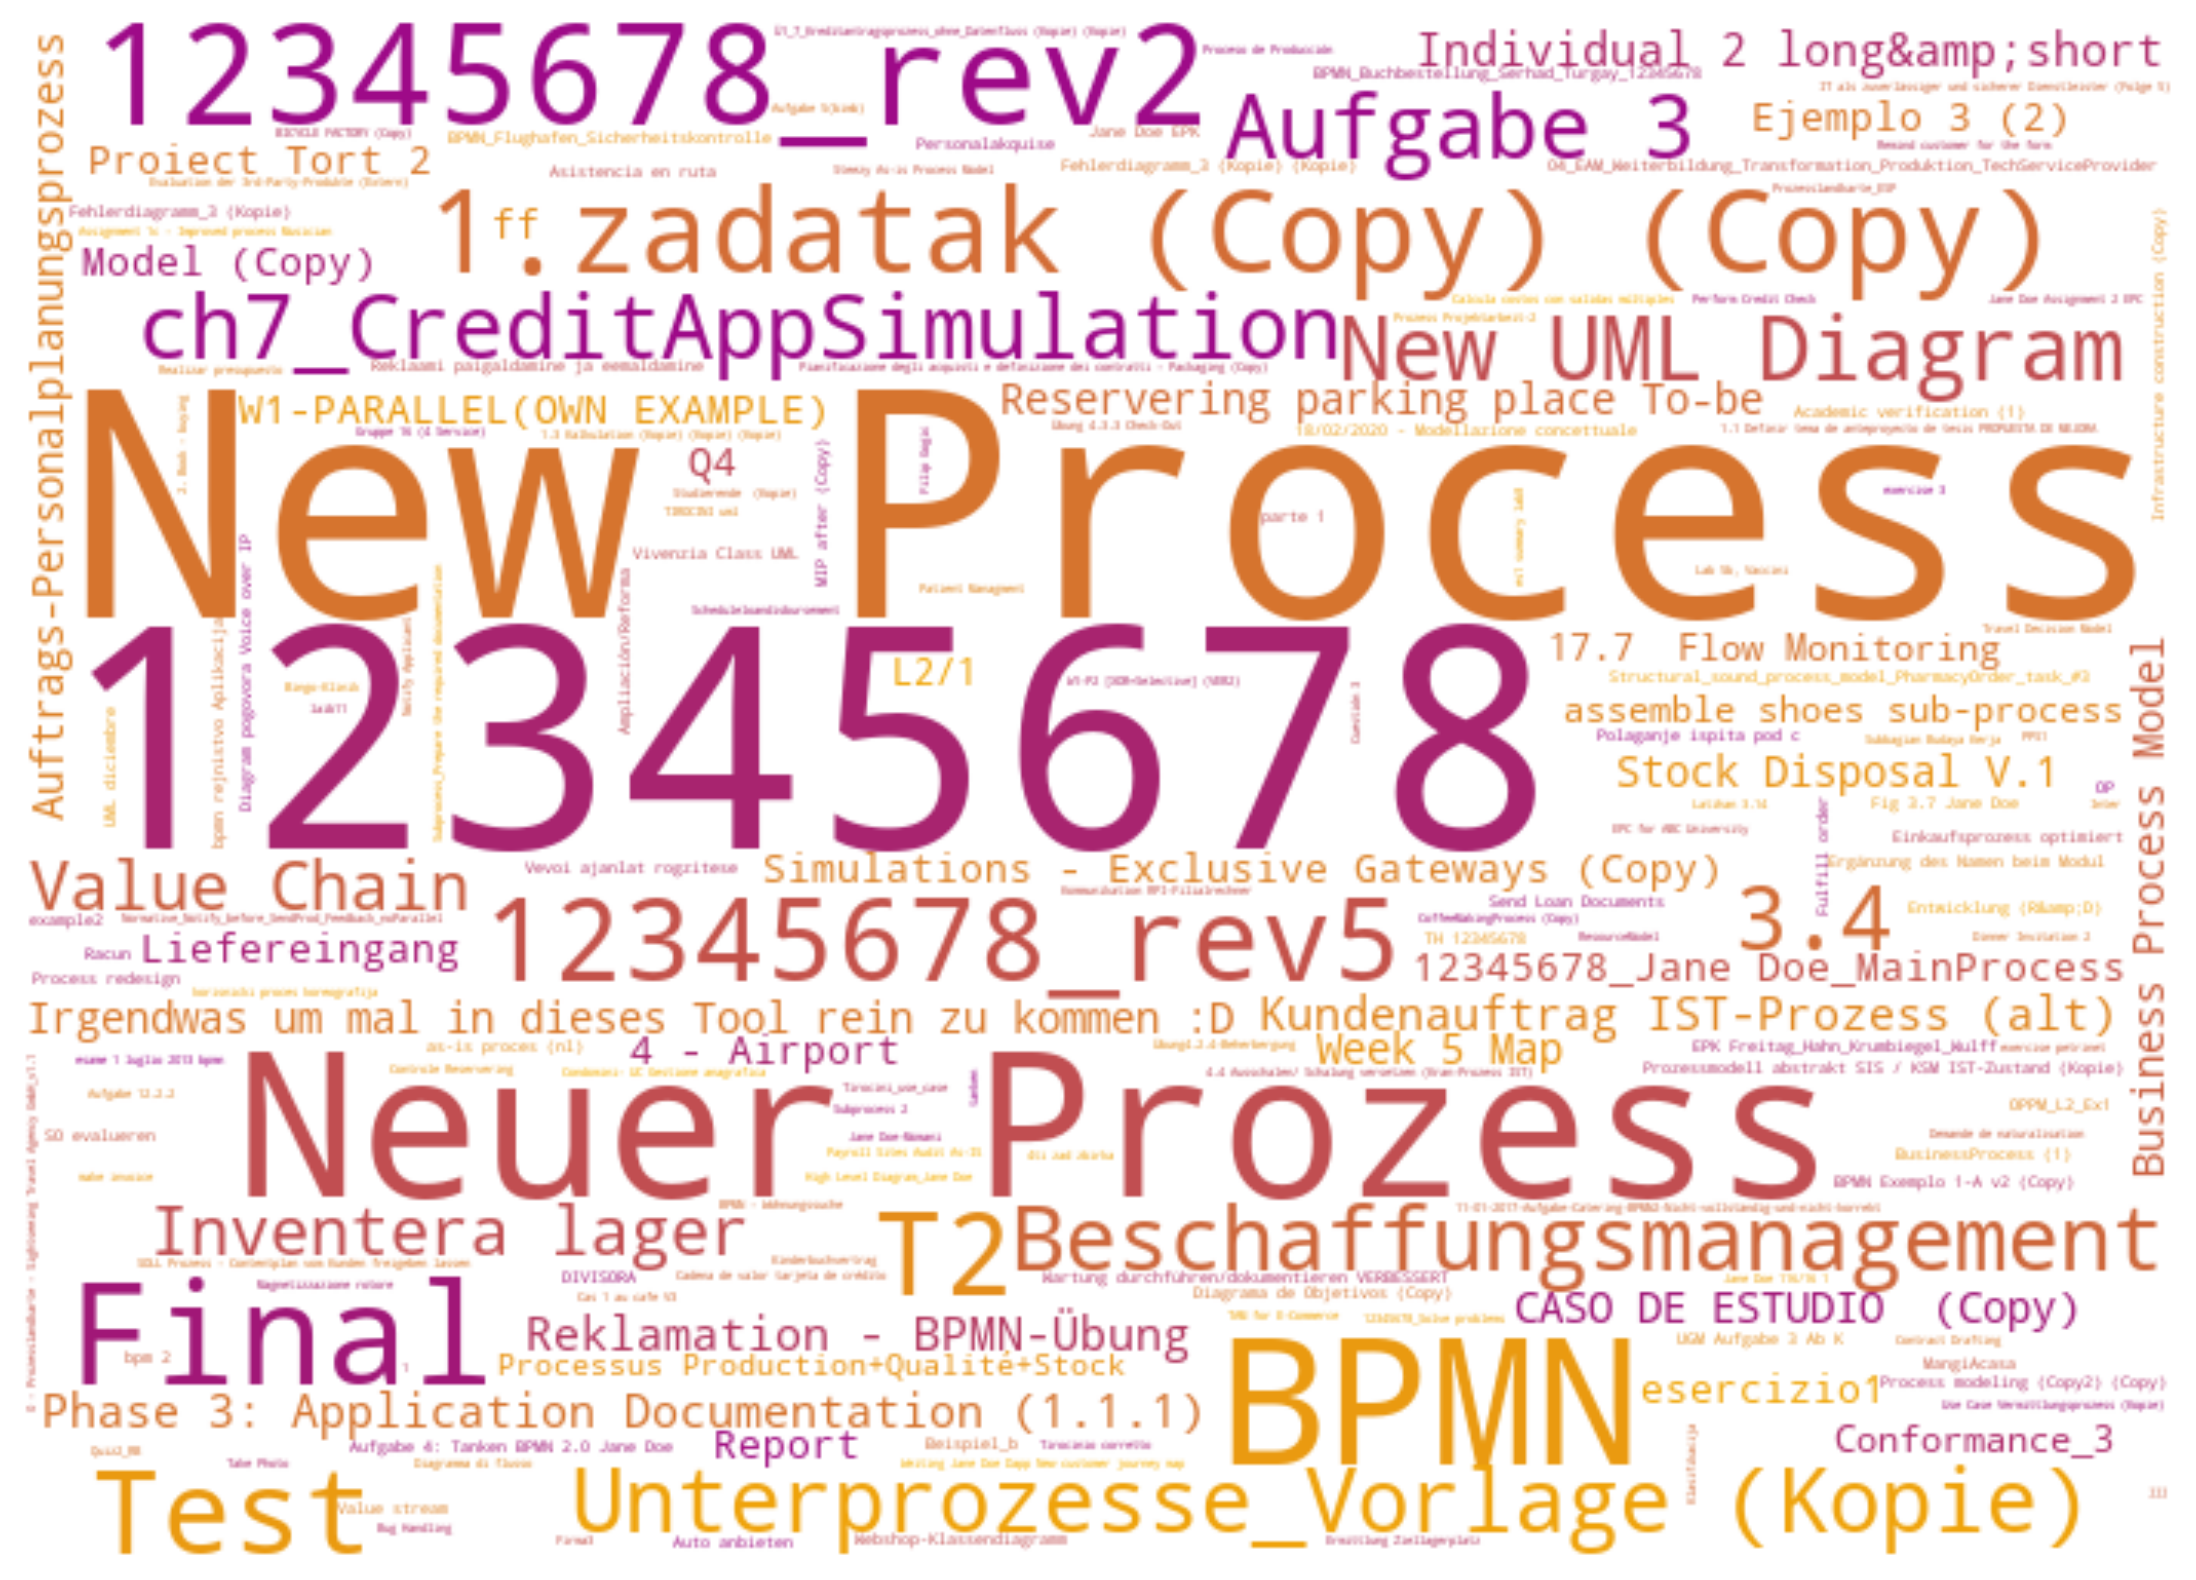

In [80]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [81]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No          178
1       Yes          147
2        no          109
3        Ja           89
4       yes           81
5      Nein           80
6        ja           40
7  Customer           33
8      nein           33
9        NO           27

The number of distinct element labels:

In [82]:
len(cnts_labels)

10405

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [83]:
len(df_bpmn)

27904

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [84]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.29245995769114536

... while 64.9 % of the labels are used for only one element.

In [85]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.9064872657376262

In [86]:
len(cnts_labels[cnts_labels.occurrences==1])

9432

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [87]:
bins = cnts_labels
bins.head()

label  occurrences
0    No          178
1   Yes          147
2    no          109
3    Ja           89
4   yes           81

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [88]:
N = 10000
bins = bins.groupby(bins.index // N).sum(numeric_only=True)

In [89]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0        12831           10000
1          405           20000

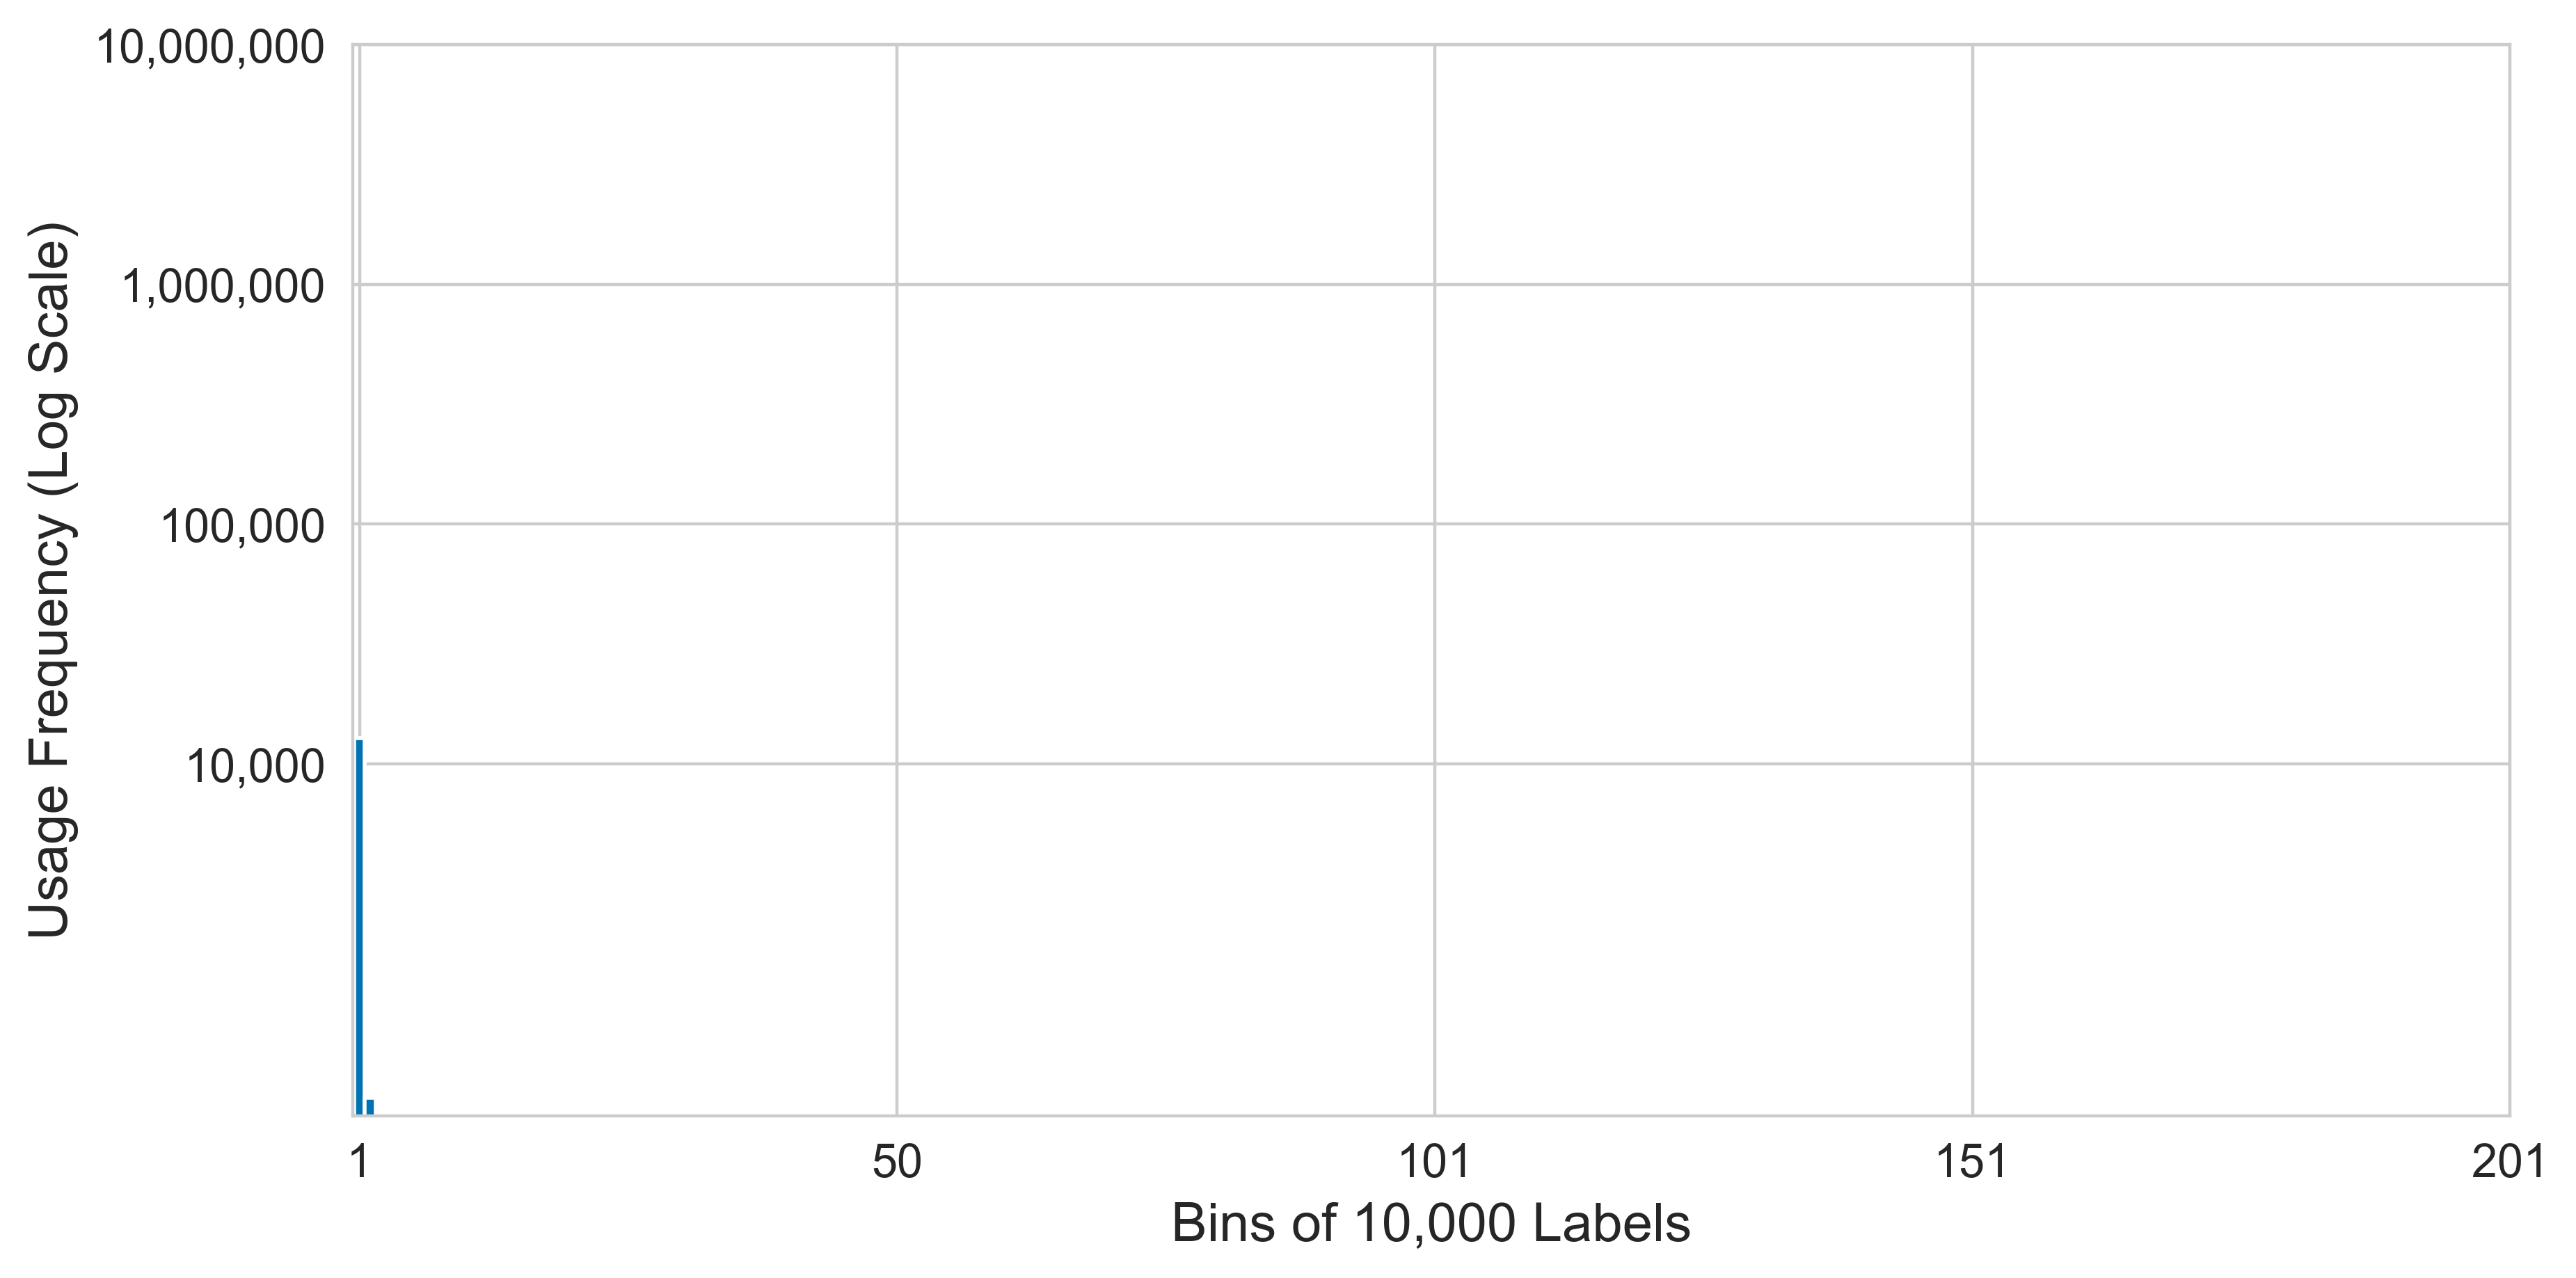

In [90]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

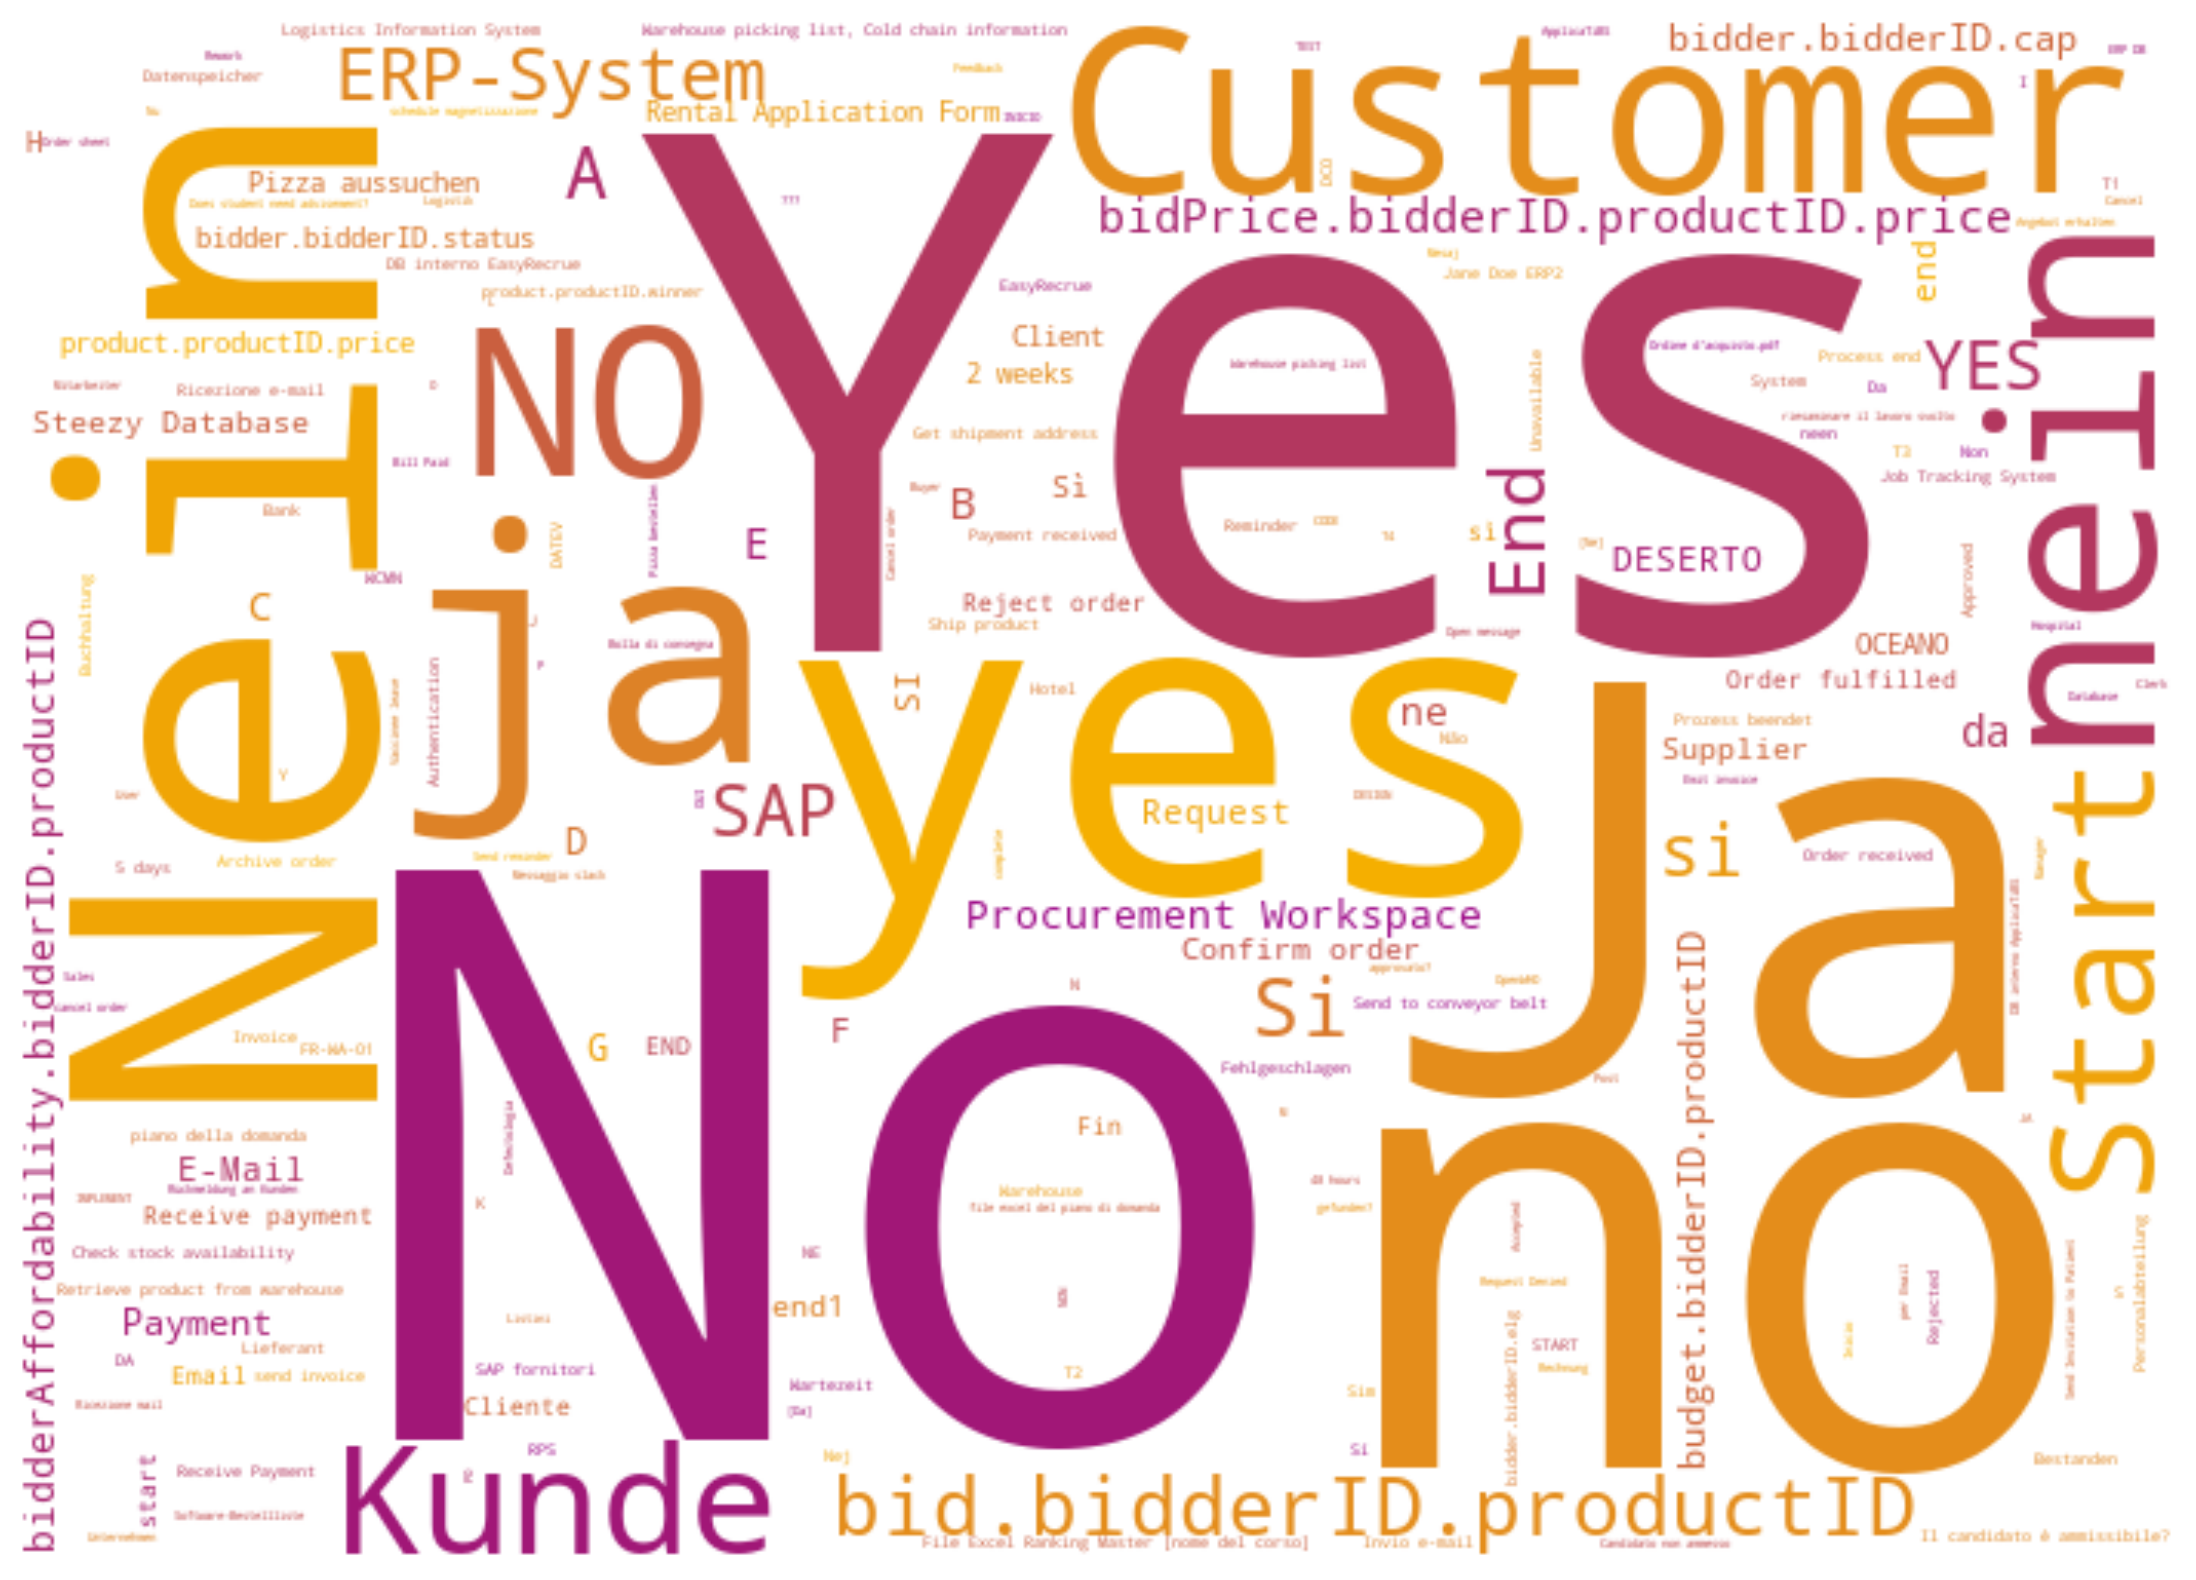

In [91]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()